In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[16,10]

from scipy import stats
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
from sklearn.impute import KNNImputer
from sklearn.preprocessing import PowerTransformer,StandardScaler,MinMaxScaler,RobustScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.feature_selection import SequentialFeatureSelector,RFE
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score,RepeatedStratifiedKFold,KFold,StratifiedKFold
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay,RocCurveDisplay,roc_curve,roc_auc_score,classification_report
from sklearn.svm import SVC

import lime
import lime.lime_tabular
import eli5
import shap

# Data Understanding

In [82]:
df=pd.read_csv(r'D:\DATA SCEINCE\1. GL\3. PROJECT\CAPSTONE\churn.csv')

In [4]:
df.describe().T

count           mean            std  \
first_payment_amount                   104143.0      34.771353      73.181032   
age                                    104001.0      32.688291       7.821752   
number_of_cards                        103671.0       1.989148       1.871436   
payments_initiated                     103671.0       2.847402       4.223077   
payments_failed                        103671.0       0.439940       1.061101   
payments_completed                     103671.0       1.830676       3.210357   
payments_completed_amount_first_7days  103671.0      55.965381     130.720128   
reward_purchase_count_first_7days       80879.0       2.042075       3.731290   
coins_redeemed_first_7days             103671.0      22.494102      64.122134   
visits_feature_1                       101497.0       0.239643       0.624616   
visits_feature_2                       101497.0       0.126861       0.445573   
given_permission_1                     104143.0       0.852318       0.354786   
given_permission_2                     104143.0       0.723332       0.447353   
user_id                                104143.0  251829.347273  146009.671697   
is_churned                             104143.0       0.286808       0.452273   

                                        min       25%       50%       75%  \
first_payment_amount                    0.0       2.0      12.0      37.0   
age                                    20.0      27.0      31.0      36.0   
number_of_cards                         0.0       1.0       1.0       3.0   
payments_initiated                      1.0       1.0       2.0       3.0   
payments_failed                         0.0       0.0       0.0       0.0   
payments_completed                      1.0       1.0       1.0       2.0   
payments_completed_amount_first_7days   0.0       3.0      21.0      64.0   
reward_purchase_count_first_7days       0.0       0.0       1.0       3.0   
coins_redeemed_first_7days              0.0       0.0       3.0      20.0   
visits_feature_1                        0.0       0.0       0.0       0.0   
visits_feature_2                        0.0       0.0       0.0       0.0   
given_permission_1                      0.0       1.0       1.0       1.0   
given_permission_2                      0.0       0.0       1.0       1.0   
user_id                                 0.0  124478.5  252377.0  378186.5   
is_churned                              0.0       0.0       0.0       1.0   

                                            max  
first_payment_amount                     4370.0  
age                                        80.0  
number_of_cards                            30.0  
payments_initiated                        359.0  
payments_failed                            30.0  
payments_completed                        337.0  
payments_completed_amount_first_7days   11107.0  
reward_purchase_count_first_7days         304.0  
coins_redeemed_first_7days               8857.0  
visits_feature_1                           17.0  
visits_feature_2                           23.0  
given_permission_1                          1.0  
given_permission_2                          1.0  
user_id                                503533.0  
is_churned                                  1.0

In [ ]:
df.info()

In [6]:
#drop 'Unnamed: 0',user_id
#covert is_chunred to object
#is_referral to object
#given_permission_1 and given_permission_2 to object


In [83]:
df.drop(['user_id'],axis=1,inplace=True)

In [18]:
df.is_referral=df.is_referral.astype('object')
df.is_churned=df.is_churned.astype('object')
df.given_permission_1= df.given_permission_1.astype('object')
df.given_permission_2= df.given_permission_2.astype('object')

In [9]:
df.nunique()

device                                    76
first_payment_amount                     717
age                                       61
city                                     751
number_of_cards                           29
payments_initiated                       104
payments_failed                           25
payments_completed                        92
payments_completed_amount_first_7days    985
reward_purchase_count_first_7days         94
coins_redeemed_first_7days               249
is_referral                                2
visits_feature_1                          16
visits_feature_2                          14
given_permission_1                         2
given_permission_2                         2
is_churned                                 2
dtype: int64

In [10]:
print('no. of numerical columns:',len(df.select_dtypes(include='number').columns))
print('no. of categorical columns:',len(df.select_dtypes(include='object').columns))

no. of numerical columns: 11
no. of categorical columns: 6


In [11]:
for i in df.select_dtypes(include='object').columns:
    print('no of observations in {} are:\n {}'.format(i,df[i].value_counts(normalize=True)*100))
    print('---------------------------')

no of observations in device are:
 xiaomi         24.041336
samsung        16.012497
apple          15.199231
oneplus        14.047585
vivo            8.193223
                 ...    
leeco           0.000961
yuho            0.000961
inone           0.000961
fortuneship     0.000961
karbonn         0.000961
Name: device, Length: 76, dtype: float64
---------------------------
no of observations in city are:
 NCR                   14.895067
Bangalore             13.932717
Mumbai                10.661133
Hyderabad              9.914446
Pune                   4.561500
                        ...    
Ganjam                 0.001017
Mahabalipuram Town     0.001017
Chandipur              0.001017
Mormugao               0.001017
azamgarh               0.001017
Name: city, Length: 751, dtype: float64
---------------------------
no of observations in is_referral are:
 False    58.596353
True     41.403647
Name: is_referral, dtype: float64
---------------------------
no of observations in given_

In [120]:
df_num=df.select_dtypes(include='number')
df_cat=df.select_dtypes(include='object')

# Univariate, Bivariate and Multivariate Analysis

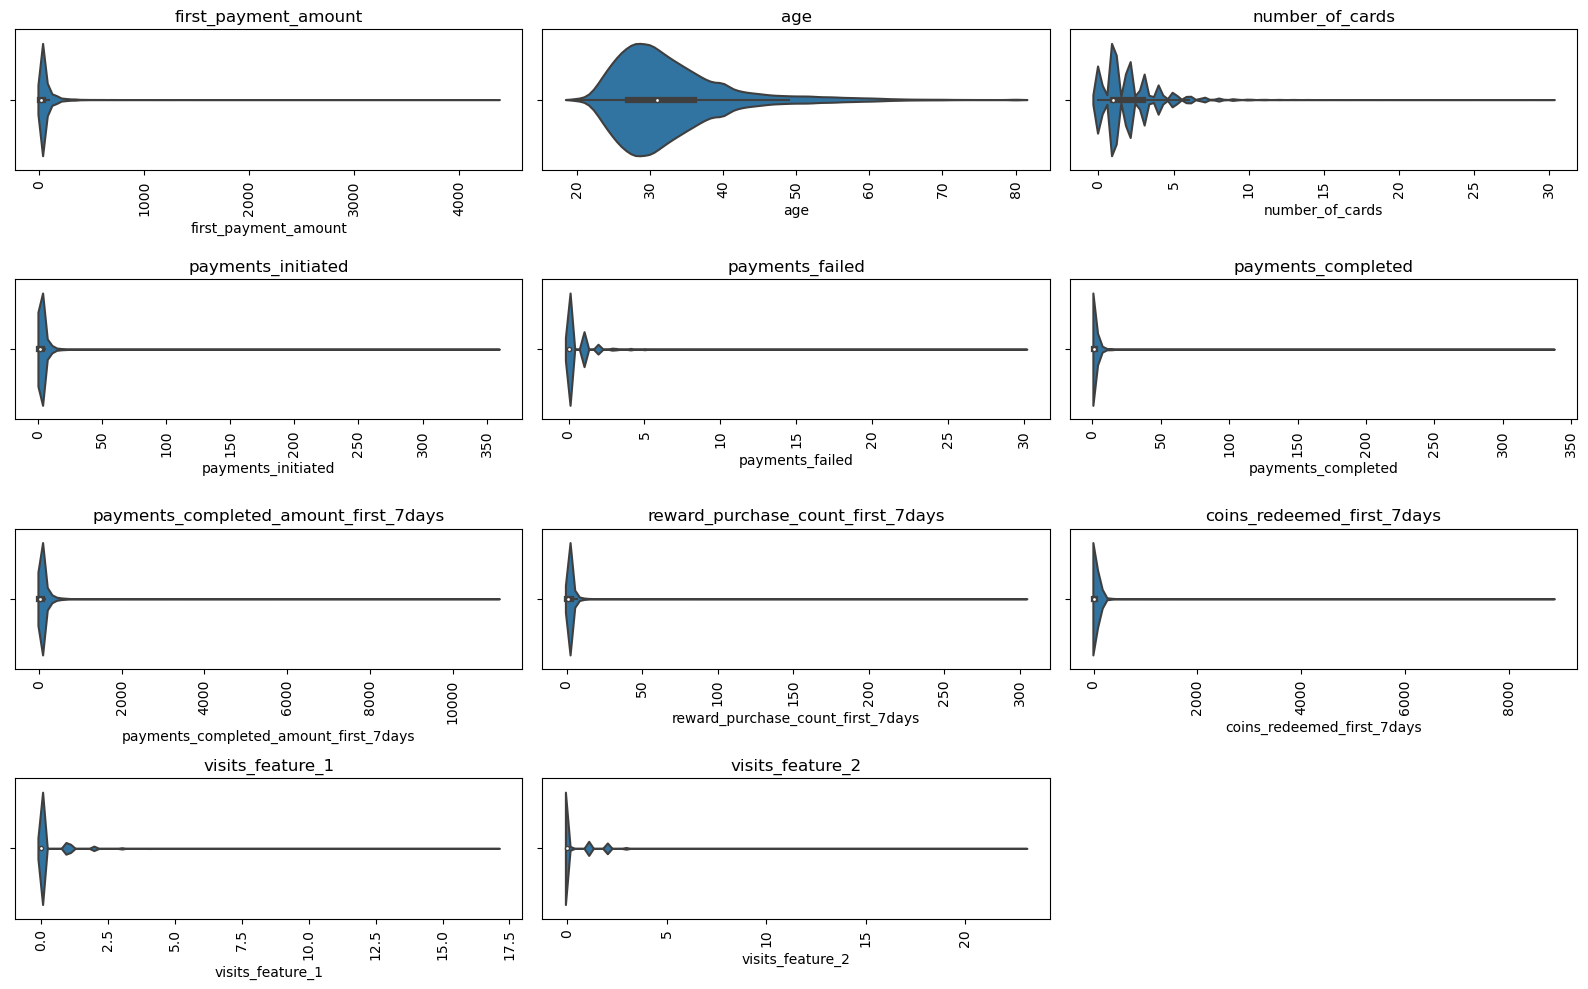

In [13]:
c=1
for i in df_num.columns:
    plt.subplot(4,3,c)
    sns.violinplot(x=df[i],hue=df['is_churned'])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()

c=1
for i in df_cat.columns:
    plt.subplot(8,3,c)
    sns.swarmplot(x=df[i],hue=c)
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

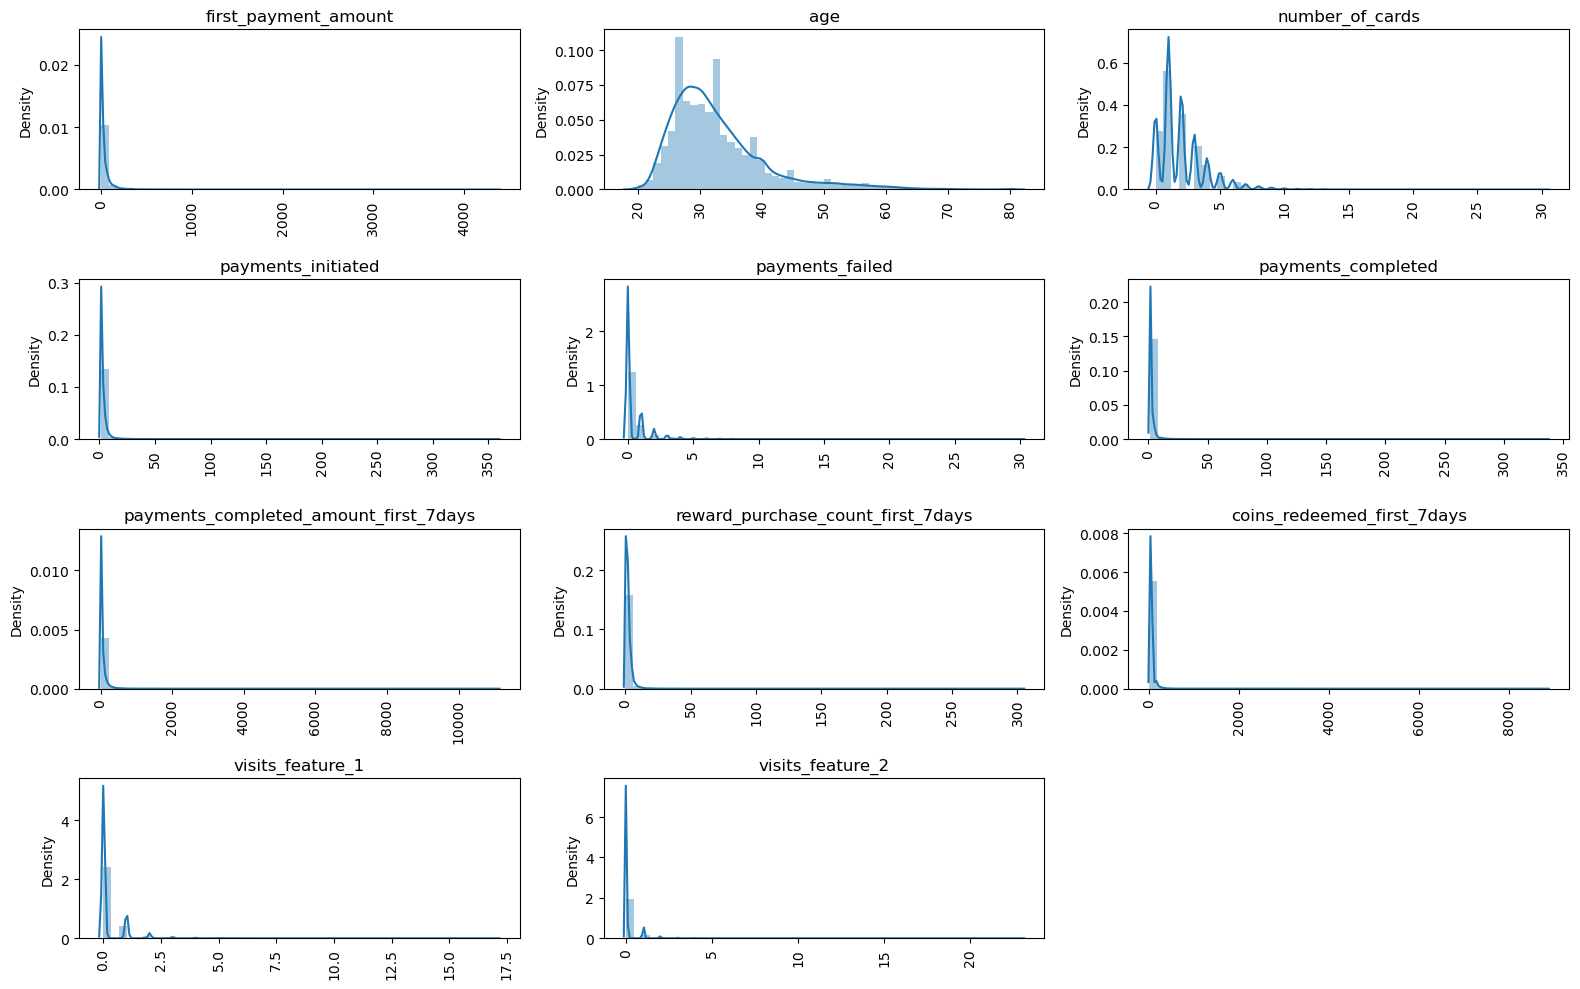

In [14]:
c=1

for i in df_num.columns:
    plt.subplot(4,3,c)
    sns.distplot(x=df[i])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()


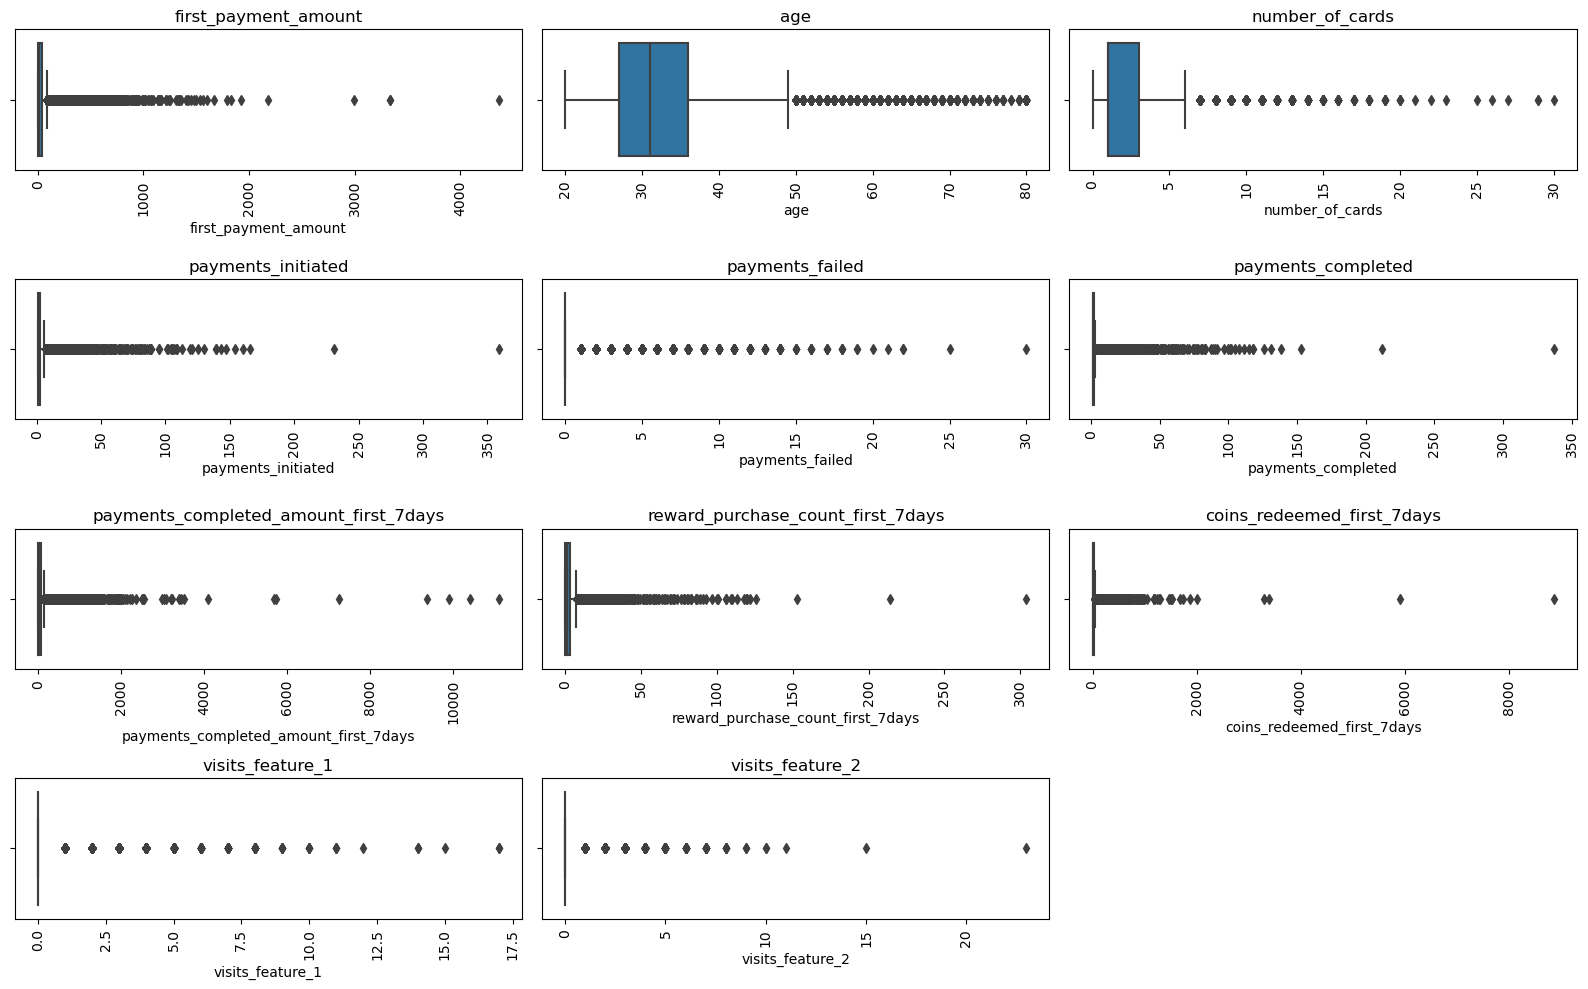

In [15]:
c=1
for i in df_num.columns:
    plt.subplot(4,3,c)
    sns.boxplot(x=df[i])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_5816\890553192.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


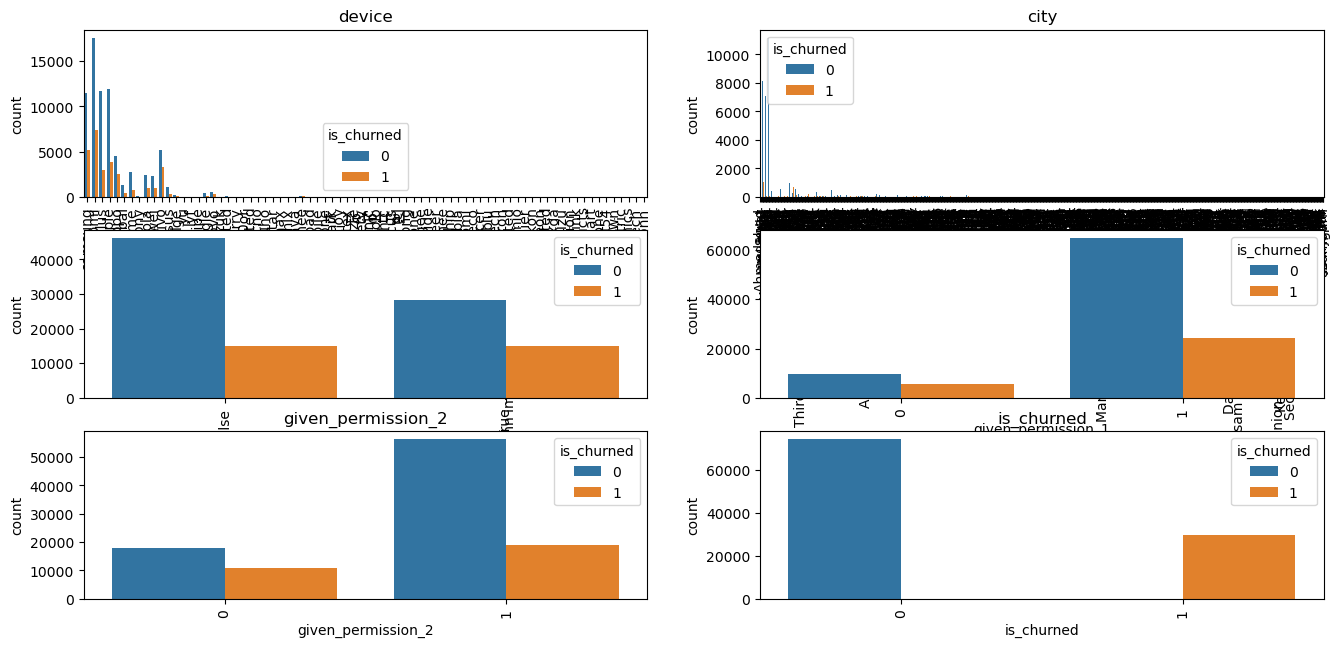

In [16]:
c=1
plt.figure(figsize=[16,10])
for i in df_cat.columns:
    plt.subplot(4,2,c)
    sns.countplot(x=df[i],hue=df['is_churned'])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()

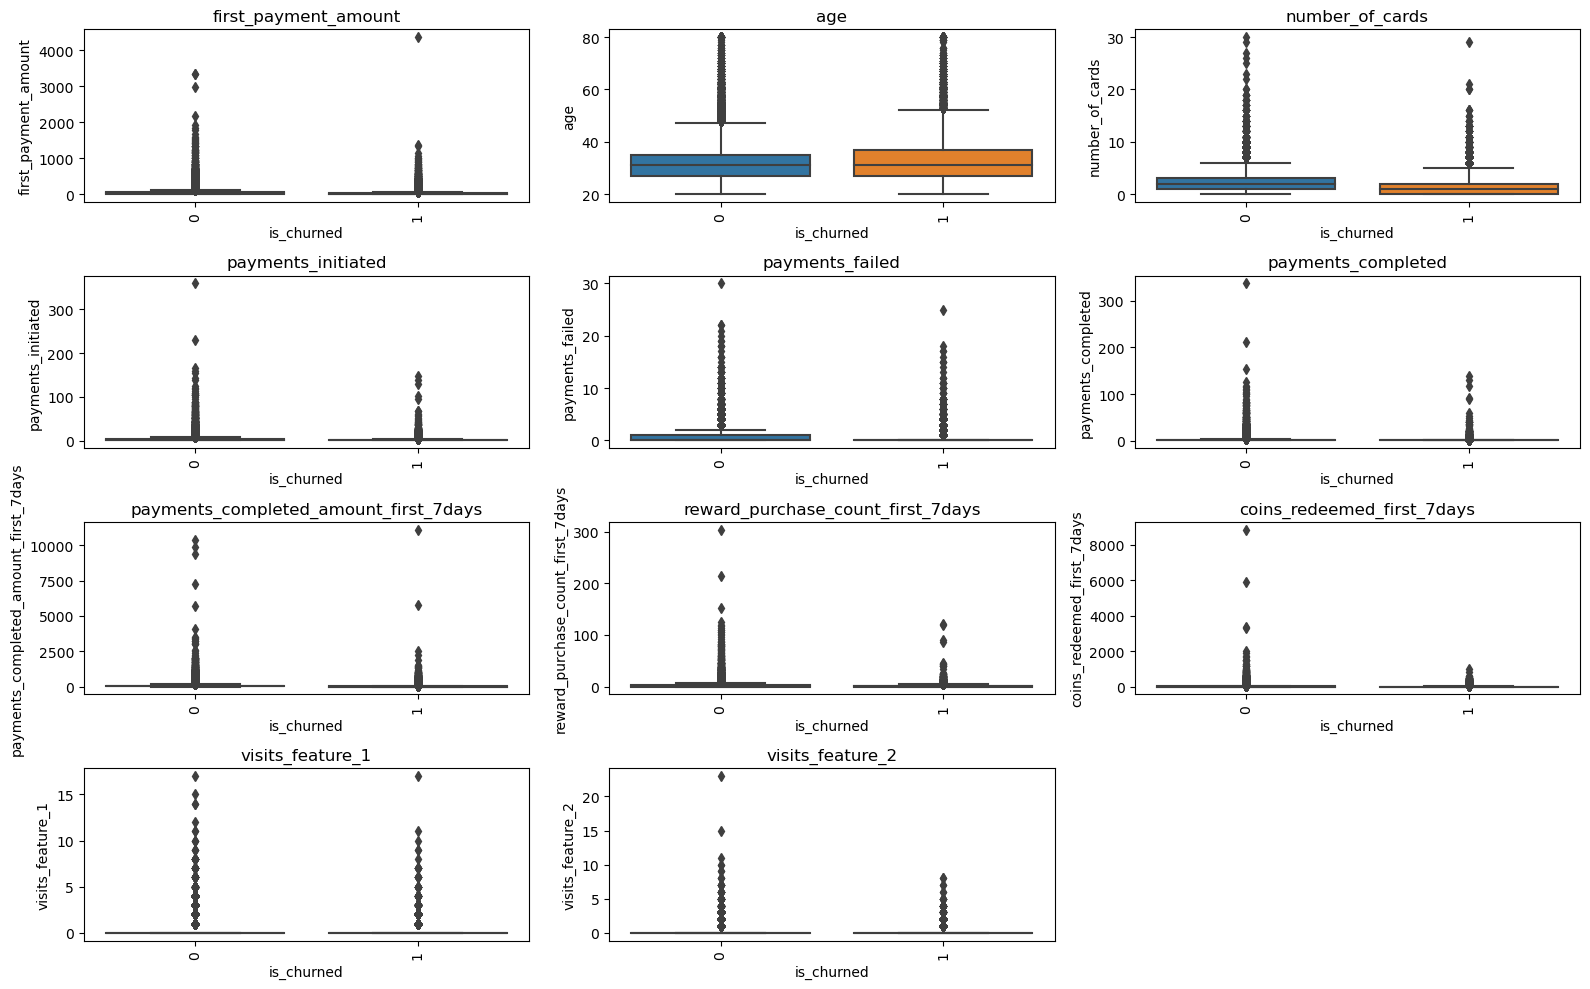

In [17]:
c=1
for i in df_num.columns:
    plt.subplot(4,3,c)
    sns.boxplot(y=df[i],x=df['is_churned'])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()

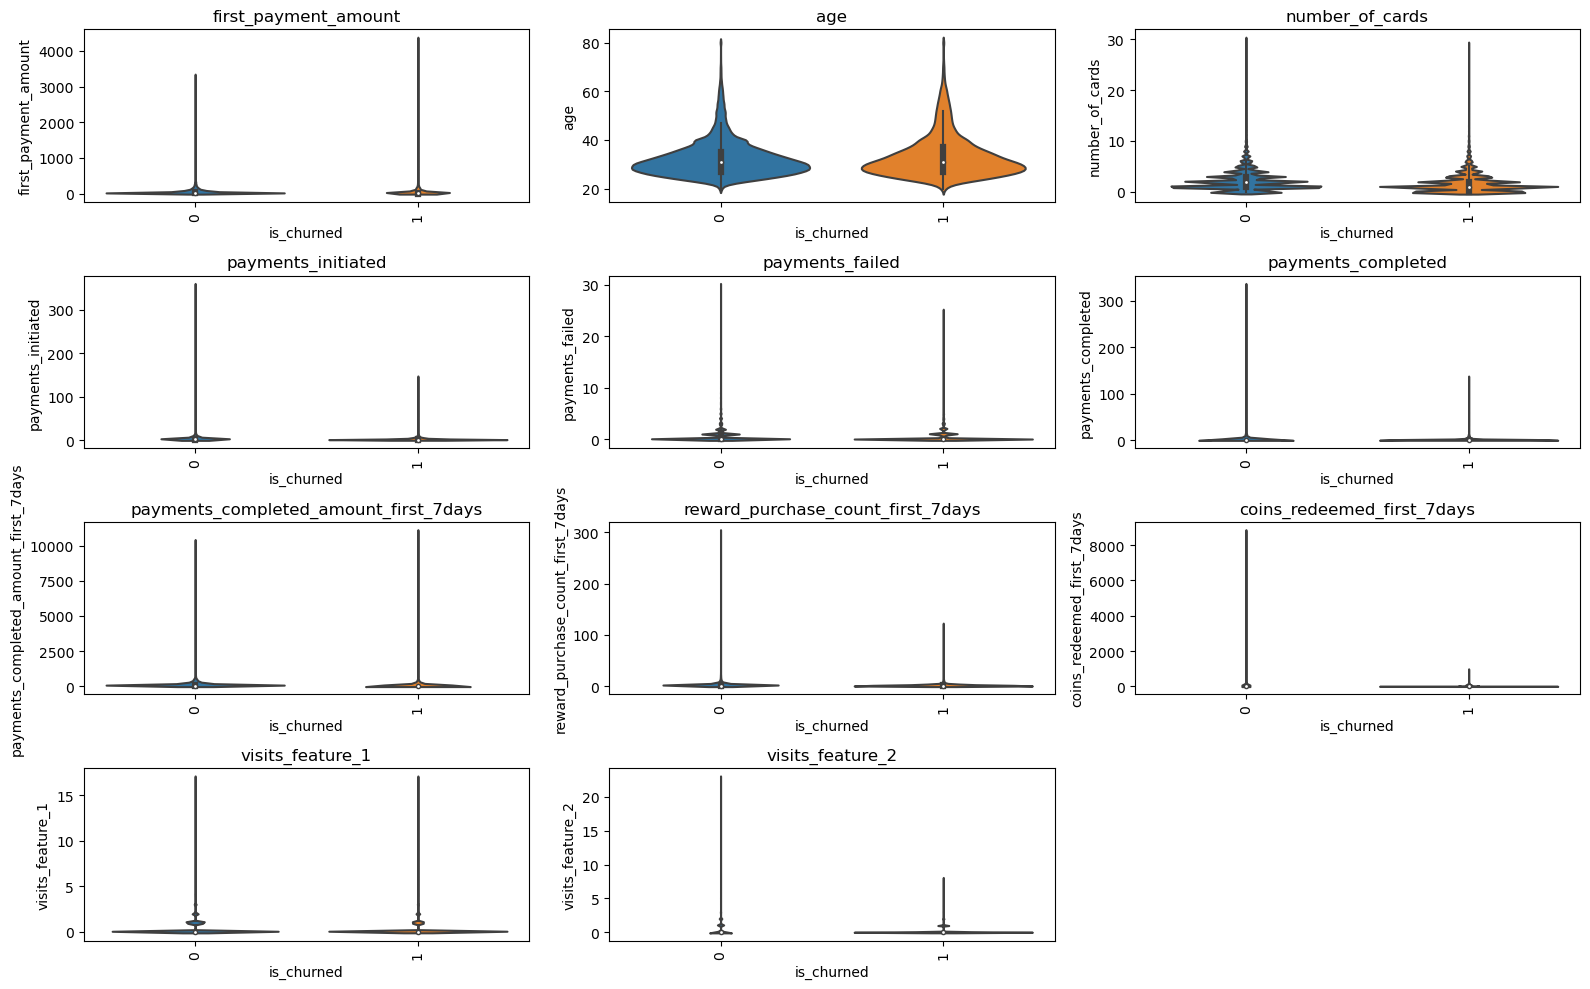

In [18]:
c=1
for i in df_num.columns:
    plt.subplot(4,3,c)
    sns.violinplot(y=df[i],x=df['is_churned'])
    c+=1
    plt.xticks(rotation=90)
    plt.title(i)
plt.tight_layout()
plt.show()

pd.plotting.scatter_matrix(df[['first_payment_amount',
 'age',
 'number_of_cards',
 'payments_initiated',
 'payments_failed',
 'payments_completed',
 'payments_completed_amount_first_7days',
 'reward_purchase_count_first_7days',
 'coins_redeemed_first_7days',
 'visits_feature_1',
 'visits_feature_2',
 'given_permission_1',
 'given_permission_2']], figsize=(10, 10))
plt.xticks(rotation=90)
plt.show()

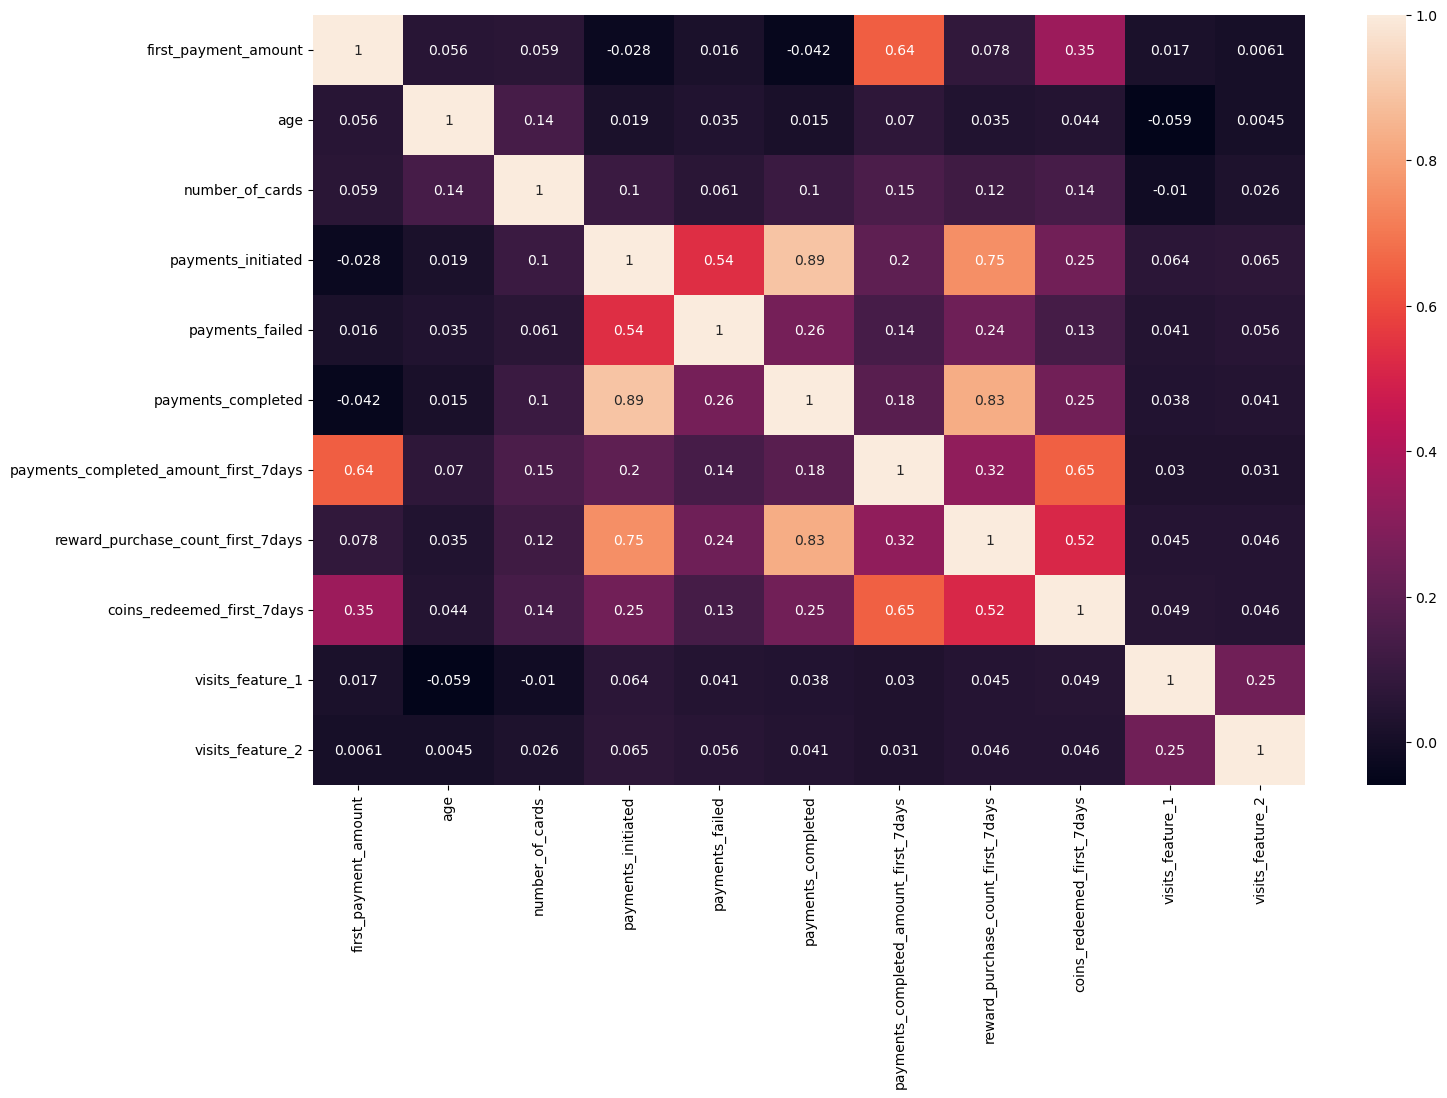

In [19]:
sns.heatmap(df_num.corr(),annot=True)
plt.show()

In [ ]:
#no scatter matric

# Null Values (detection and treatment)

In [20]:
df.isnull().sum()

device                                     118
first_payment_amount                         0
age                                        142
city                                      5842
number_of_cards                            472
payments_initiated                         472
payments_failed                            472
payments_completed                         472
payments_completed_amount_first_7days      472
reward_purchase_count_first_7days        23264
coins_redeemed_first_7days                 472
is_referral                                  0
visits_feature_1                          2646
visits_feature_2                          2646
given_permission_1                           0
given_permission_2                           0
is_churned                                   0
dtype: int64

In [21]:
Total = df.isnull().sum().sort_values(ascending=False)  
Percent = (df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([Total, Percent], axis = 1, keys = ['Total', 'Percentage of Missing Values'])    
missing_data

Total  Percentage of Missing Values
reward_purchase_count_first_7days      23264                     22.338515
city                                    5842                      5.609594
visits_feature_1                        2646                      2.540737
visits_feature_2                        2646                      2.540737
payments_completed_amount_first_7days    472                      0.453223
number_of_cards                          472                      0.453223
payments_initiated                       472                      0.453223
payments_failed                          472                      0.453223
payments_completed                       472                      0.453223
coins_redeemed_first_7days               472                      0.453223
age                                      142                      0.136351
device                                   118                      0.113306
is_referral                                0                      0.000000
first_payment_amount                       0                      0.000000
given_permission_1                         0                      0.000000
given_permission_2                         0                      0.000000
is_churned                                 0                      0.000000

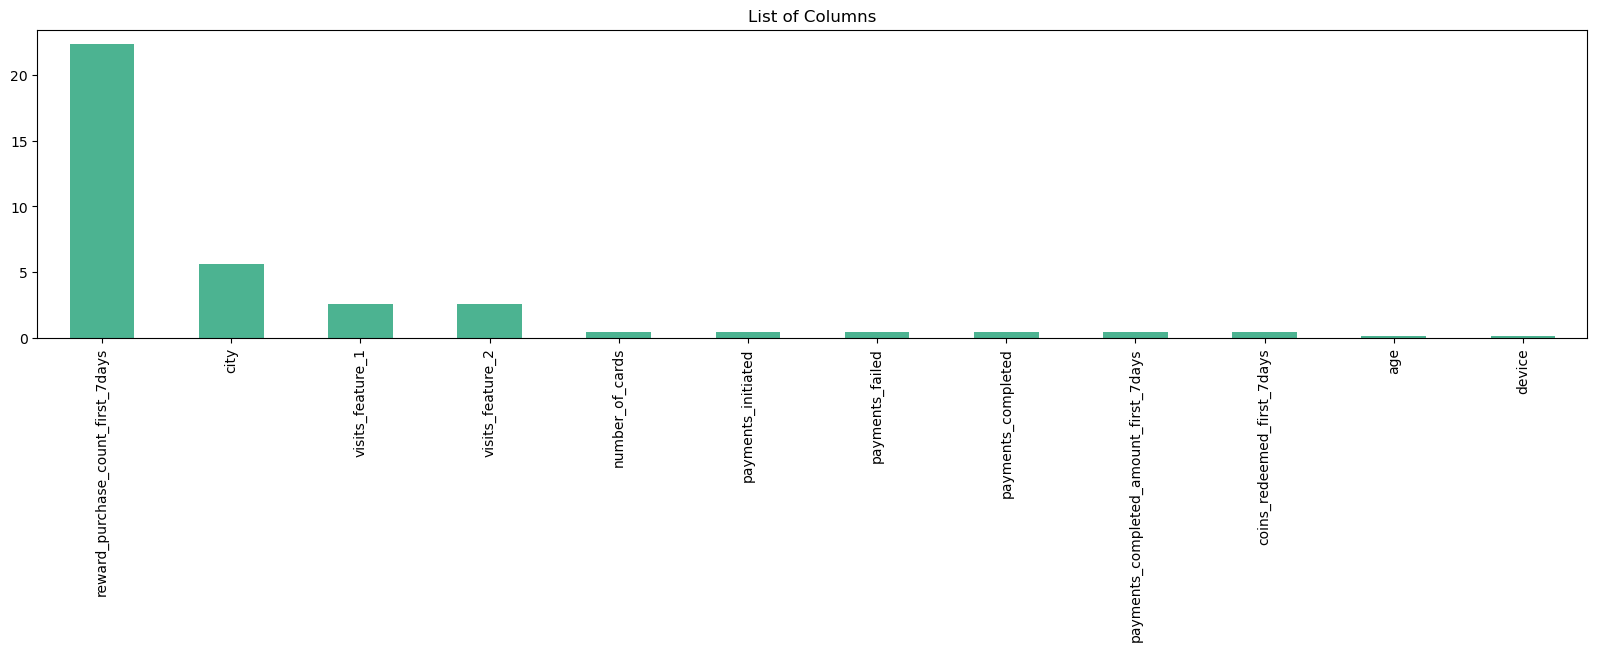

(104143, 17)


In [22]:
NA_col = df.isnull().sum()/len(df)*100
c = NA_col[NA_col.values >0].sort_values(ascending = False)
plt.figure(figsize=(20,4))
c.plot(kind='bar', color="#4CB391")
plt.title('List of Columns')
plt.show()
print(df.shape)

In [6]:
#df.age.fillna(value=df.age.median(), inplace=True)

In [7]:
#df.city.fillna(value=df.city.mode()[0], inplace=True)

In [8]:
#df.device.fillna(value=df.device.mode()[0], inplace=True)

In [84]:
df.drop('reward_purchase_count_first_7days', axis=1, inplace=True)

In [11]:
#df.dropna(['number_of_cards','payments_initiated','payments_failed','payments_completed','payments_completed_amount_first_7days','coins_redeemed_first_7days'], thresh=3,inplace=True)

In [85]:
df.dropna(inplace=True)

# Stastical test

In [29]:
# Test for categorical and numerical columns
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
#H0: the two groups have no significant difference.
#H1: the two groups have significant difference.

for i in df.drop('is_churned', axis=1).columns:
    if df[i].dtypes=='object':
        observed=pd.crosstab(df[i],df['is_churned'])
        z_stat,p_val,ddof,exp=chi2_contingency(observed, correction=False)
        print(f'p value for {i} and is_churned is {p_val}')
        print('---------------------------------------')
    else:
        z_stat, p_val=ttest_ind(df[i], df['is_churned'].astype('float'))
        print(f'p value for {i} and is_churned is {p_val}')
        print('----------------------------------------')

p value for device and is_churned is 2.1447238069413714e-297
---------------------------------------
p value for first_payment_amount and is_churned is 0.0
----------------------------------------
p value for age and is_churned is 0.0
----------------------------------------
p value for city and is_churned is 0.0
---------------------------------------
p value for number_of_cards and is_churned is 0.0
----------------------------------------
p value for payments_initiated and is_churned is 0.0
----------------------------------------
p value for payments_failed and is_churned is 0.0
----------------------------------------
p value for payments_completed and is_churned is 0.0
----------------------------------------
p value for payments_completed_amount_first_7days and is_churned is 0.0
----------------------------------------
p value for coins_redeemed_first_7days and is_churned is 0.0
----------------------------------------
p value for is_referral and is_churned is 1.5331473714308956

In [30]:
#ttest_ind
#H0: the two variables (the grouping variable and the outcome) are independent
#H1: the two variables (the grouping variable and the outcome) are dependent

#chi2_contingency
#H0: no relationship exists on the categorical variables in the population; they are independent.
#H: relationship exists on the categorical variables in the population; they are dependent.

In [31]:
# all are significant features

In [32]:
stats.f_oneway(df.payments_initiated,df.payments_failed,df.payments_completed)
#H0: means are equal(there are no differnce)
#H1: means are not eqaul(there are differnce)

F_onewayResult(statistic=15140.158076424306, pvalue=0.0)

# Featrure Engineering

In [101]:
df.is_referral=df.is_referral.map({False:0,True:1})

In [102]:
df.is_referral=df.is_referral.astype('object')

In [161]:
df1=df.copy()

In [171]:
df2=dff.copy()

In [172]:
df1['Amount_Type']=pd.cut(x=df.payments_completed_amount_first_7days, bins=[-1,0,25,50,100,10000], labels=['no payment','v_small','medium','large','v_large'])

In [26]:
df2['Amount_Type']=pd.cut(x=df.payments_completed_amount_first_7days, bins=[-1,0,25,50,100,10000], labels=['no payment','v_small','medium','large','v_large'])

In [173]:
temp2=df.groupby('city')['payments_initiated'].sum().reset_index().sort_values(by=['payments_initiated'],ascending=False)

In [174]:
temp2=df2.groupby('city')['payments_initiated'].sum().reset_index().sort_values(by=['payments_initiated'],ascending=False)

In [175]:
temp2['city_type']=pd.cut(x=temp2.payments_initiated, bins=[-1,1000,10000,20000,30000,60000], labels=['Tier 5','Tier 4','Tier 3','Tier 2','Tier 1'])

In [176]:
dict1=dict()
for k,v in zip(temp2['city'],temp2['city_type']):
    dict1[k]=v

In [177]:
df1['city_type']=df1['city'].map(dict1)

In [32]:
df2['city_type']=df2['city'].map(dict1)

In [178]:
# for deivices:
major_devices = ['xiaomi','samsung','apple','oneplus','vivo','oppo']
def device_club(x):
    if x in major_devices:
        return x
    else:
        return "other"

In [179]:
df1.device=df1.device.apply(device_club)

In [35]:
df2.device=df2.device.apply(device_club)

In [43]:
pd.crosstab(index=df1.is_churned, columns=df1.Amount_Type)

Amount_Type  no payment  v_small  medium  large  v_large
is_churned                                              
0                  5416    27940   13291  12623    13347
1                 10079    11132    3034   2402     2231

In [44]:
pd.crosstab(index=df1.is_churned, columns=df1.city_type)

city_type   Tier 1  Tier 2  Tier 3  Tier 4  Tier 5
is_churned                                        
0            24968   14940    3361   15263   14086
1             8356    4822    1020    8657    6024

In [45]:
pd.crosstab(index=df1.is_churned, columns=df1.device)

device      apple  oneplus  oppo  other  samsung  vivo  xiaomi
is_churned                                                    
0           11478    11456  4457  11606    11214  5050   17357
1            3628     2881  2470   4373     5042  3253    7232

In [186]:
df1.Amount_Type= df1.Amount_Type.astype('object')

In [37]:
df2.Amount_Type= df2.Amount_Type.astype('object')

In [47]:
#test for featured datat frame
for i in df1.drop('is_churned', axis=1).columns:
    if df1[i].dtypes=='object':
        observed=pd.crosstab(df1[i],df1['is_churned'])
        z_stat,p_val,ddof,exp=chi2_contingency(observed, correction=False)
        print(f'p value for {i} and is_churned is {p_val}')
        print('---------------------------------------')
    else:
        print('----------------------------------------')

p value for device and is_churned is 5.880359266468329e-290
---------------------------------------
----------------------------------------
----------------------------------------
p value for city and is_churned is 0.0
---------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
----------------------------------------
p value for is_referral and is_churned is 1.5331473714308956e-262
---------------------------------------
----------------------------------------
----------------------------------------
p value for given_permission_1 and is_churned is 1.0691368223009516e-138
---------------------------------------
p value for given_permission_2 and is_churned is 9.42334816720206e-302
---------------------------------------
p value for Amount_Type and is_churned is 0.0
-----------------------------------

In [188]:
df1.drop(['city'],axis=1,inplace=True)

In [71]:
df2.drop(['city'],axis=1,inplace=True)

In [50]:
#df[df[['number_of_cards','payments_initiated','payments_failed','payments_completed','payments_completed_amount_first_7days','coins_redeemed_first_7days']].isnull().any(axis=1)]
#as the null values accomodates with all the above columns as 472 rows, its safe to safe theres data entry error and drop these values

# Logistic Stats Base Model 

In [21]:
X=df.drop(columns=['is_churned','device','city'],axis=1)
y=df.is_churned

In [22]:
XC= sm.add_constant(X)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(XC, y.astype('float'), random_state = 42, test_size = 0.3)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66901, 14), (28673, 14), (66901,), (28673,))

In [25]:
pt=PowerTransformer()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.fit_transform(X_test[[i]])

In [26]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [27]:
model=sm.Logit(y_train.astype('float'),X_train)
result=model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.507731
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                                    Results: Logit
Model:                     Logit                   Pseudo R-squared:        0.136     
Dependent Variable:        is_churned              AIC:                     67963.3564
Date:                      2023-03-14 22:04        BIC:                     68090.9100
No. Observations:          66901                   Log-Likelihood:          -33968.   
Df Model:                  13                      LL-Null:                 -39335.   
Df Residuals:              66887                   LLR p-value:             0.0000    
Converged:                 0.0000                  Scale:                   1.0000    
--------------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------

from firthlogist import FirthLogisticRegression, load_endometrial
X, y, feature_names = load_endometrial()
fl = FirthLogisticRegression()
fl.fit(X, y)
FirthLogisticRegression()
fl.summary(xname=feature_names)

In [28]:
train_prob = result.predict(X_train)
test_prob = result.predict(X_test)

In [29]:
train_pred = [0 if val<0.5 else 1 for val in train_prob ]
test_pred = [0 if val<0.5 else 1 for val in test_prob ]

In [30]:
from sklearn.metrics import log_loss
print('log_loss test',log_loss(y_test, test_pred))
print('log_loss train',log_loss(y_train, train_pred))

log_loss test 7.7057006415032845
log_loss train 7.662987172057154


In [31]:
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))

The train accuracy score is 0.778134855981226
The test accuracy score is 0.7768981271579535


In [32]:
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))

The column kappa value is  0.34984490611460406


In [33]:
print('train tables\n',metrics.classification_report(y_train, train_pred),'\n')
print('test tables\n',metrics.classification_report(y_test,test_pred))

train tables
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86     48518
         1.0       0.68      0.36      0.47     18383

    accuracy                           0.78     66901
   macro avg       0.74      0.65      0.67     66901
weighted avg       0.76      0.78      0.75     66901
 

test tables
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86     20653
         1.0       0.70      0.36      0.47      8020

    accuracy                           0.78     28673
   macro avg       0.74      0.65      0.67     28673
weighted avg       0.76      0.78      0.75     28673



In [140]:
#cm= metrics.confusion_matrix(y_test,test_pred)
#ConfusionMatrixDisplay(cm)
#fpr,tpr,threshold=metrics.roc_curve(y_test,test_pred)
#RocCurveDisplay(fpr,tpr)

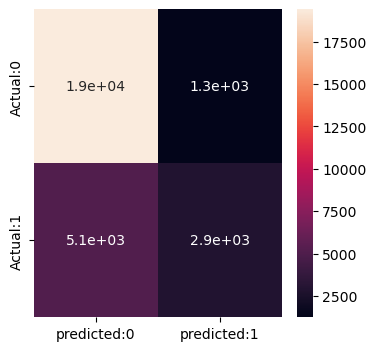

In [34]:
cm= metrics.confusion_matrix(y_test,test_pred)
matrix=pd.DataFrame(data=cm,index=['Actual:0','Actual:1'], columns=['predicted:0','predicted:1'])
plt.figure(figsize=(4,4))
sns.heatmap(matrix, annot=True)
plt.show()

In [142]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

AUC_score 0.6607389107225354


fpr, tpr, thresholds = roc_curve(y_test, test_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC curve for Admission Prediction Classifier (Full Model)', fontsize = 15)
plt.xlabel('False positive rate (1-Specificity)', fontsize = 15)
plt.ylabel('True positive rate (Sensitivity)', fontsize = 15)
plt.text(x = 0.02, y = 0.9, s = ('AUC Score:', round(metrics.roc_auc_score(y_test, test_prob),4)))
plt.grid(True)
plt.show()

# Using Train-Test Method # With Outliers Models

In [35]:
df.reset_index(inplace=True,drop=True)
#df.reset_index()

In [20]:
#df=df.drop(['index'],axis=1)

In [36]:
X=df.drop(columns=['is_churned','device','city'],axis=1).reset_index()
y=df.is_churned

In [37]:
X=X.drop('index',axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X.astype('float'), y.astype('float'), random_state = 42, test_size = 0.3)

In [39]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66901, 13), (28673, 13), (66901,), (28673,))

In [40]:
pt=StandardScaler()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.fit_transform(X_test[[i]])

In [41]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [42]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66901, 13), (28673, 13), (66901,), (28673,))

# Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression()
lr.fit(X_train,y_train.astype('float'))

train_prob = lr.predict(X_train)
test_prob = lr.predict(X_test)
train_pred = [0 if val<0.5 else 1 for val in train_prob ]
test_pred = [0 if val<0.5 else 1 for val in test_prob ]


print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.74      0.98      0.85     48518
         1.0       0.71      0.11      0.19     18383

    accuracy                           0.74     66901
   macro avg       0.73      0.55      0.52     66901
weighted avg       0.73      0.74      0.67     66901

              precision    recall  f1-score   support

         0.0       0.74      0.99      0.84     20653
         1.0       0.74      0.09      0.17      8020

    accuracy                           0.74     28673
   macro avg       0.74      0.54      0.51     28673
weighted avg       0.74      0.74      0.65     28673

The train accuracy score is 0.7431279054124752
The test accuracy score is 0.7373138492658599
The column kappa value is  0.11058831777666567
AUC_score 0.5405296043047371


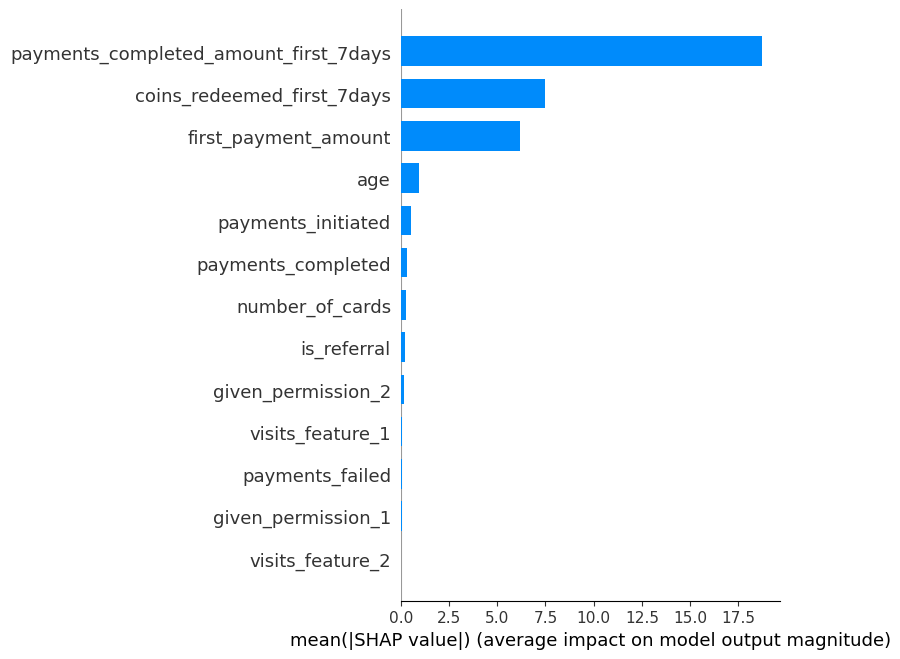

In [45]:
explain=shap.LinearExplainer(lr,X)
value=explain.shap_values(X)
shap.summary_plot(value, X, plot_type='bar', feature_names=X.columns)
plt.show()


In [47]:
fn=['first_payment_amount', 'age', 'number_of_cards', 'payments_initiated',
       'payments_failed', 'payments_completed',
       'payments_completed_amount_first_7days',
       'reward_purchase_count_first_7days', 'coins_redeemed_first_7days',
       'is_referral', 'visits_feature_1', 'visits_feature_2',
       'given_permission_1', 'given_permission_2']

In [48]:
explainer=lime.lime_tabular.LimeTabularExplainer(X.values,feature_names=fn,class_names=[0,1])



In [49]:
exp=explainer.explain_instance(X.iloc[10],lr.predict_proba,num_features=14,top_labels=1,num_samples=5000)

In [50]:
exp.show_in_notebook()

# Logistic Regression using Recursive Feature Elimination (RFE)

In [148]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator = lr)
rfe.fit(X_train,y_train)

RFE(estimator=LogisticRegression())

In [149]:
feat_index = pd.Series(data = rfe.ranking_, index = X_train.columns)
signi_feat_rfe = feat_index[feat_index==1].index
print(signi_feat_rfe,feat_index)
# select the features with rank = 1

Index(['const', 'first_payment_amount', 'payments_completed',
       'coins_redeemed_first_7days', 'is_referral_1', 'given_permission_1_1',
       'given_permission_2_1'],
      dtype='object') const                                    1
first_payment_amount                     1
age                                      3
number_of_cards                          2
payments_initiated                       6
payments_failed                          7
payments_completed                       1
payments_completed_amount_first_7days    4
coins_redeemed_first_7days               1
visits_feature_1                         5
visits_feature_2                         8
is_referral_1                            1
given_permission_1_1                     1
given_permission_2_1                     1
dtype: int32


# DecisionTreeClassifier

In [51]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, max_features= 'log2',
                           min_samples_split = 2, max_leaf_nodes = 9, random_state = 42)
dt.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=4, max_features='log2', max_leaf_nodes=9,
                       random_state=42)

In [52]:
train_pred = dt.predict(X_train)
test_pred = dt.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.79      0.94      0.85     48518
         1.0       0.66      0.32      0.43     18383

    accuracy                           0.77     66901
   macro avg       0.72      0.63      0.64     66901
weighted avg       0.75      0.77      0.74     66901

              precision    recall  f1-score   support

         0.0       0.78      0.92      0.85     20653
         1.0       0.64      0.34      0.44      8020

    accuracy                           0.76     28673
   macro avg       0.71      0.63      0.65     28673
weighted avg       0.74      0.76      0.73     28673

The train accuracy score is 0.768807641141388
The test accuracy score is 0.7612387960799358
The column kappa value is  0.30906852498002313
AUC_score 0.6325294291024002


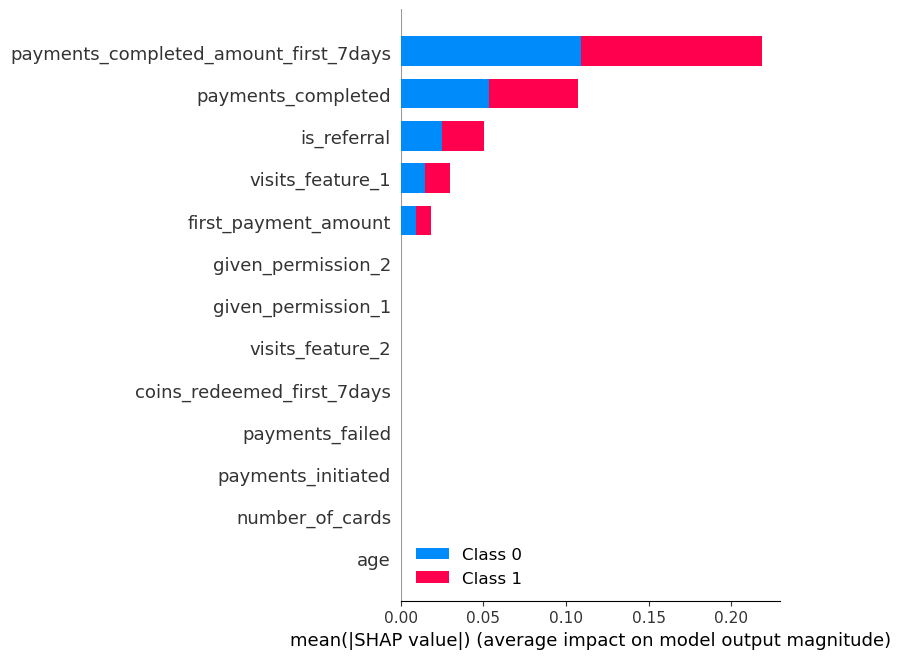

In [53]:
explain=shap.TreeExplainer(dt,X_test)
value=explain.shap_values(X_test)
shap.summary_plot(value, X_test, plot_type='bar', feature_names=X.columns)

# RandomForestClassifier

In [54]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=5)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=10, min_samples_split=20,
                       n_estimators=5)

In [55]:
train_pred = rf.predict(X_train)
test_pred = rf.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.87     48518
         1.0       0.72      0.38      0.50     18383

    accuracy                           0.79     66901
   macro avg       0.76      0.66      0.68     66901
weighted avg       0.78      0.79      0.76     66901

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85     20653
         1.0       0.69      0.30      0.42      8020

    accuracy                           0.77     28673
   macro avg       0.73      0.62      0.64     28673
weighted avg       0.75      0.77      0.73     28673

The train accuracy score is 0.7886877625147606
The test accuracy score is 0.7664701984445297
The column kappa value is  0.30057043275455864
AUC_score 0.6245298153686137


100%|===================| 57236/57346 [02:38<00:00]        

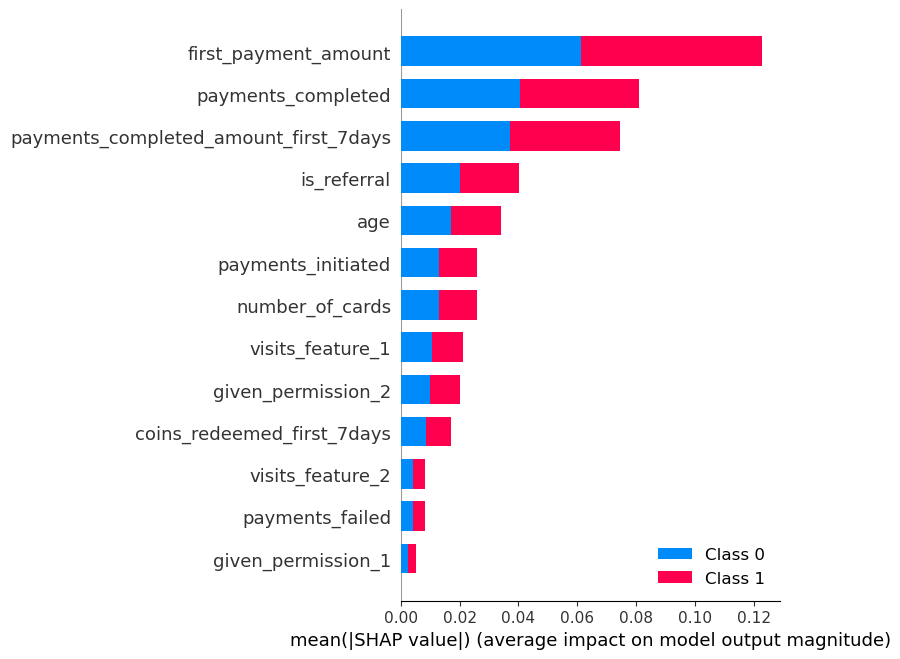

In [56]:
explain=shap.TreeExplainer(rf,X_test)
value=explain.shap_values(X_test)
shap.summary_plot(value, X_test, plot_type='bar', feature_names=X.columns)

In [57]:
train_pred = rf.predict(X_train[:25])

In [58]:
explain=shap.TreeExplainer(rf,X_test.iloc[:24])
value=explain.shap_values(X_test.iloc[:24])
shap.initjs()
shap.force_plot(explain.expected_value[0],value[0],X_test.iloc[:24])
#shap.summary_plot(value, X_train.iloc[:24], plot_type='bar', feature_names=X.columns)

In [59]:
explainer=lime.lime_tabular.LimeTabularExplainer(X.values,feature_names=fn,class_names=[0,1])

In [60]:
exp=explainer.explain_instance(X.iloc[10],rf.predict_proba,num_features=14,top_labels=1,num_samples=5000)

In [61]:
exp.show_in_notebook()

# K Nearest Neighbors (KNN)

In [62]:
from sklearn.neighbors import KNeighborsClassifier
knnc = KNeighborsClassifier(n_neighbors = 5)
knnc.fit(X_train, y_train)

KNeighborsClassifier()

In [64]:
train_pred = knnc.predict(X_train)
test_pred = knnc.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87     48518
         1.0       0.71      0.47      0.57     18383

    accuracy                           0.80     66901
   macro avg       0.77      0.70      0.72     66901
weighted avg       0.79      0.80      0.79     66901

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83     20653
         1.0       0.53      0.32      0.40      8020

    accuracy                           0.73     28673
   macro avg       0.65      0.60      0.61     28673
weighted avg       0.70      0.73      0.71     28673

The train accuracy score is 0.8016023676776132
The test accuracy score is 0.7296760018135529
The column kappa value is  0.23517807516123435
AUC_score 0.6031454011559972


In [ ]:
explainer=lime.lime_tabular.LimeTabularExplainer(X.values,feature_names=fn,class_names=[0,1])
exp=explainer.explain_instance(X.iloc[10],knnc.predict_proba,num_features=14,top_labels=1,num_samples=5000)
exp.show_in_notebook()

# GaussianNB

In [203]:
from sklearn.naive_bayes import GaussianNB
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train,y_train)

GaussianNB()

In [49]:
train_pred = gaussian_nb.predict(X_train)
test_pred = gaussian_nb.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.86      0.71      0.78     43499
         1.0       0.24      0.44      0.31      8943

    accuracy                           0.67     52442
   macro avg       0.55      0.58      0.54     52442
weighted avg       0.75      0.67      0.70     52442

              precision    recall  f1-score   support

         0.0       0.86      0.70      0.77     18614
         1.0       0.24      0.44      0.31      3862

    accuracy                           0.66     22476
   macro avg       0.55      0.57      0.54     22476
weighted avg       0.75      0.66      0.69     22476

The train accuracy score is 0.6656496701117425
The test accuracy score is 0.6592810108560242
The column kappa value is  0.10757541826586792
AUC_score 0.5721545851485133


In [65]:
explainer=lime.lime_tabular.LimeTabularExplainer(X.values,feature_names=fn,class_names=[0,1])
exp=explainer.explain_instance(X.iloc[10],knnc.predict_proba,num_features=14,top_labels=1,num_samples=5000)
exp.show_in_notebook()

# Boosting Methods

#  XGBClassifier

In [199]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(max_depth = 10, gamma = 1)
xgbc.fit(X_train,y_train) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [34]:
train_pred = xgbc.predict(X_train)
test_pred = xgbc.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.87      0.99      0.93     43499
         1.0       0.88      0.28      0.42      8943

    accuracy                           0.87     52442
   macro avg       0.88      0.63      0.67     52442
weighted avg       0.87      0.87      0.84     52442

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90     18614
         1.0       0.42      0.10      0.16      3862

    accuracy                           0.82     22476
   macro avg       0.63      0.53      0.53     22476
weighted avg       0.77      0.82      0.77     22476

The train accuracy score is 0.870256664505549
The test accuracy score is 0.8215429791777896
The column kappa value is  0.09880176165795662
AUC_score 0.5343719419132746


In [70]:
eli5.show_weights(xgbc,target_names=[0,1],feature_names=fn)

In [71]:
eli5.show_prediction(xgbc,X_test.iloc[0].astype(float))

# GradientBoostingClassifier

In [200]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators = 150, max_depth = 10, random_state=42)
gb.fit(X_train,y_train)

GradientBoostingClassifier(max_depth=10, n_estimators=150, random_state=42)

In [162]:
train_pred = gb.predict(X_train)
test_pred = gb.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85     50898
         1.0       0.65      0.30      0.41     20149

    accuracy                           0.76     71047
   macro avg       0.71      0.62      0.63     71047
weighted avg       0.74      0.76      0.72     71047

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.84     21720
         1.0       0.65      0.31      0.42      8730

    accuracy                           0.75     30450
   macro avg       0.71      0.62      0.63     30450
weighted avg       0.74      0.75      0.72     30450

The train accuracy score is 0.755204301377961
The test accuracy score is 0.7547783251231527
The column kappa value is  0.28671041393638363
AUC_score 0.6204972059260947


In [ ]:
#eli5.show_weights(gb,target_names=[0,1],feature_names=fn)

#  AdaBoost

In [201]:
from sklearn.ensemble import AdaBoostClassifier
abc= AdaBoostClassifier(n_estimators = 40, random_state = 42)
abc.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=40, random_state=42)

In [164]:
train_pred = abc.predict(X_train)
test_pred = abc.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.85     50898
         1.0       0.65      0.30      0.41     20149

    accuracy                           0.76     71047
   macro avg       0.71      0.62      0.63     71047
weighted avg       0.74      0.76      0.72     71047

              precision    recall  f1-score   support

         0.0       0.77      0.94      0.84     21720
         1.0       0.65      0.31      0.42      8730

    accuracy                           0.75     30450
   macro avg       0.71      0.62      0.63     30450
weighted avg       0.74      0.75      0.72     30450

The train accuracy score is 0.755204301377961
The test accuracy score is 0.7547783251231527
The column kappa value is  0.28671041393638363
AUC_score 0.6204972059260947


In [ ]:
#eli5.show_weights(abc,target_names=[0,1],feature_names=fn)

# Comparing All Models Together

## (a)Power Transformation

In [167]:
pt=PowerTransformer()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.fit_transform(X_test[[i]])

In [168]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [171]:
# fit all the models at once

clfs = {
    'Logreg' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Ada Boost' : AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'XgBoost' : XGBClassifier(),
    'SVC':SVC() 
}

models_report = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'roc auc', 'f1 score'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Fitting model...', clf_name)
    t = {'model name' : clf_name,
        'accuracy' : metrics.accuracy_score(y_test,y_pred),
        'recall' : metrics.recall_score(y_test,y_pred),
        'precision' : metrics.precision_score(y_test,y_pred),
        'roc auc' : metrics.roc_auc_score(y_test,y_pred),
        'f1 score' : metrics.f1_score(y_test,y_pred),
        }
    models_report = models_report.append(t, ignore_index=True)

models_report = models_report.sort_values(by='f1 score', ascending=False)
models_report

Fitting model... Logreg
Fitting model... KNN
Fitting model... Naive Bayes
Fitting model... Decision Tree
Fitting model... Random Forest
Fitting model... Ada Boost
Fitting model... Gradient Boost
Fitting model... XgBoost


model name  accuracy    recall  precision   roc auc  f1 score
2     Naive Bayes  0.716995  0.578601   0.502330  0.675317  0.537775
6  Gradient Boost  0.782611  0.392313   0.715052  0.665070  0.506652
5       Ada Boost  0.779163  0.391794   0.699969  0.662504  0.502387
7         XgBoost  0.776798  0.393006   0.688923  0.661216  0.500496
0          Logreg  0.776059  0.390755   0.687272  0.660022  0.498234
1             KNN  0.746552  0.404432   0.578075  0.643520  0.475909
4   Random Forest  0.757783  0.380886   0.621293  0.644278  0.472255
3   Decision Tree  0.658522  0.474896   0.412978  0.603222  0.441778

## (b)Standard Scalar

In [67]:
sc=StandardScaler()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=sc.fit_transform(X_train[[i]])
    X_test[i]=sc.fit_transform(X_test[[i]])
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [183]:
# fit all the models at once

clfs = {
    'Logreg' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Ada Boost' : AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'XgBoost' : XGBClassifier(),
    'SVC':SVC() 
}

models_report = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'roc auc', 'f1 score'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Fitting model...', clf_name)
    t = {'model name' : clf_name,
        'accuracy' : metrics.accuracy_score(y_test,y_pred),
        'recall' : metrics.recall_score(y_test,y_pred),
        'precision' : metrics.precision_score(y_test,y_pred),
        'roc auc' : metrics.roc_auc_score(y_test,y_pred),
        'f1 score' : metrics.f1_score(y_test,y_pred),
        }
    models_report = models_report.append(t, ignore_index=True)

models_report = models_report.sort_values(by='f1 score', ascending=False)
models_report

# Finding Optimum k-folds for Cross Validation Method

In [175]:
def evaluate_model(cv):
    model = RandomForestClassifier()
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

In [176]:
folds = range(2,15)
for k in folds:
  # define the test condition
  cv = KFold(n_splits=k, shuffle=True, random_state=10)
  # record mean and min/max of each set of results
  k_mean, k_min, k_max = evaluate_model(cv)
  # report performance
  print('-> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))

-> folds=2, accuracy=0.759 (0.758,0.760)
-> folds=3, accuracy=0.758 (0.757,0.759)
-> folds=4, accuracy=0.757 (0.756,0.759)
-> folds=5, accuracy=0.757 (0.756,0.759)
-> folds=6, accuracy=0.756 (0.752,0.760)
-> folds=7, accuracy=0.757 (0.754,0.761)
-> folds=8, accuracy=0.758 (0.753,0.762)
-> folds=9, accuracy=0.758 (0.756,0.760)
-> folds=10, accuracy=0.757 (0.750,0.761)
-> folds=11, accuracy=0.757 (0.750,0.764)
-> folds=12, accuracy=0.757 (0.748,0.762)
-> folds=13, accuracy=0.757 (0.746,0.768)
-> folds=14, accuracy=0.757 (0.751,0.767)


In [177]:
def evaluate_model(cv):
    model = LogisticRegression()
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return np.mean(scores), scores.min(), scores.max()

In [183]:
folds = range(2,15)
for k in folds:
  # define the test condition
  cv = StratifiedKFold(n_splits=k,shuffle=True,random_state=42)
  # record mean and min/max of each set of results
  k_mean, k_min, k_max = evaluate_model(cv)
  # report performance
  print('-> folds=%d, accuracy=%.3f (%.3f,%.3f)' % (k, k_mean, k_min, k_max))

-> folds=2, accuracy=0.776 (0.774,0.777)
-> folds=3, accuracy=0.776 (0.775,0.778)
-> folds=4, accuracy=0.776 (0.775,0.778)
-> folds=5, accuracy=0.776 (0.774,0.781)
-> folds=6, accuracy=0.776 (0.775,0.781)
-> folds=7, accuracy=0.776 (0.770,0.779)
-> folds=8, accuracy=0.776 (0.773,0.782)
-> folds=9, accuracy=0.776 (0.770,0.780)
-> folds=10, accuracy=0.776 (0.769,0.782)
-> folds=11, accuracy=0.776 (0.769,0.784)
-> folds=12, accuracy=0.776 (0.769,0.784)
-> folds=13, accuracy=0.776 (0.768,0.781)
-> folds=14, accuracy=0.776 (0.768,0.781)


# Cross Validation Models: Without Feature Enginnering 

## (a) Power Transformation

In [61]:
X=df.drop(columns=['is_churned','device','city'],axis=1)
y=df.is_churned.astype('float')

In [63]:
pt=PowerTransformer()
Xkc=pd.get_dummies(X,drop_first=True)
Xkn=pt.fit_transform(X)

In [64]:
Xk=pd.DataFrame(Xkn,columns=X.columns)

In [65]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'NaiveBayes':GaussianNB(),
    'Gradient Boost' : GradientBoostingClassifier()  
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk,y)
    cv=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='recall')
    cv_auc=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='roc_auc')
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN
fitting model ..... RandomForest
fitting model ..... DecisionTree
fitting model ..... XGBoost


KeyboardInterrupt: 

## (b) Standard Scaler

In [ ]:
X=df.drop(columns=['is_churned','device','city'],axis=1)
y=df.is_churned.astype('float')
Xkc=pd.get_dummies(X,drop_first=True)
Xkn=sc.fit_transform(X)
Xk=pd.DataFrame(Xkn,columns=X.columns)

In [85]:
kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'NaiveBayes':GaussianNB(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'SVC':SVC() 
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk,y)
    cv=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='recall')
    cv_auc=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='roc_auc')
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN
fitting model ..... RandomForest
fitting model ..... DecisionTree
fitting model ..... XGBoost
fitting model ..... AdaBoost
fitting model ..... NaiveBayes


model name                                      recall scores  \
6           NaiveBayes  [0.5720221606648199, 0.5896814404432132, 0.572...   
3         DecisionTree  [0.45013850415512463, 0.4761080332409972, 0.45...   
5             AdaBoost  [0.3798476454293629, 0.39785318559556787, 0.38...   
0  logistic regression  [0.3815789473684211, 0.3961218836565097, 0.389...   
2         RandomForest  [0.3701523545706371, 0.39646814404432135, 0.38...   
4              XGBoost  [0.3801939058171745, 0.3992382271468144, 0.390...   
1                  KNN  [0.3029778393351801, 0.3192520775623269, 0.319...   

   recall score  variance                                     roc_auc scores  \
6      0.583227  0.009896  [0.7412321310185986, 0.7410882055186525, 0.731...   
3      0.464109  0.010685  [0.6126847024048837, 0.6261529774769585, 0.614...   
5      0.393678  0.012117  [0.7522430873800628, 0.7484670277336356, 0.745...   
0      0.391738  0.010157  [0.7467436885437877, 0.7455863959242931, 0.740...   
2      0.391080  0.011795  [0.701555158297547, 0.7109566618553225, 0.7055...   
4      0.389141  0.013542  [0.7490478077740845, 0.7504226694034365, 0.751...   
1      0.313550  0.010202  [0.6499512508096257, 0.6545365546452485, 0.635...   

    roc_auc  roc_auc_variance  
6  0.738209          0.006419  
3  0.617393          0.005697  
5  0.750663          0.005110  
0  0.745618          0.005804  
2  0.706838          0.006567  
4  0.750729          0.006814  
1  0.642990          0.009506

# Cross Validation Models: With Feature Enginnering 

## (a) Power Transformation

In [180]:
X1=df1.drop(columns=['is_churned','city'],axis=1)
y1=df1.is_churned.astype('float')

In [190]:
df1_cat=df1.select_dtypes(include='O')
df1_num=df1.select_dtypes(exclude='O')

In [156]:
#df1.reset_index(inplace=True)

In [159]:
#df1=df1.drop('index',axis=1)

In [191]:
Xkc1=pd.get_dummies(df1_cat)
Xkn1=pt.fit_transform(df1_num)

In [192]:
Xkn1=pd.DataFrame(Xkn1,columns=df1_num.columns)

In [164]:
Xk1=pd.concat([Xkc1,Xkn1],axis=1,join='inner')

In [166]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'NaiveBayes':GaussianNB()
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk1,y1)
    cv=cross_val_score(estimator=clf,X=Xk1,y=y1,cv=kf,scoring='recall')
    cv_auc=cross_val_score(estimator=clf,X=Xk1,y=y1,cv=kf,scoring='roc_auc')
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN
fitting model ..... RandomForest
fitting model ..... DecisionTree
fitting model ..... XGBoost
fitting model ..... AdaBoost
fitting model ..... NaiveBayes


model name                                      recall scores  \
6           NaiveBayes  [0.5521262002743484, 0.5742539902845246, 0.575...   
3         DecisionTree  [0.4506172839506173, 0.45454545454545453, 0.43...   
5             AdaBoost  [0.37551440329218105, 0.39035392088827203, 0.3...   
4              XGBoost  [0.3731138545953361, 0.39590562109646077, 0.38...   
1                  KNN  [0.3737997256515775, 0.39555863983344897, 0.38...   
0  logistic regression  [0.350480109739369, 0.366412213740458, 0.37453...   
2         RandomForest  [0.3487654320987654, 0.35877862595419846, 0.36...   

   recall score  variance                                     roc_auc scores  \
6      0.572960  0.010448  [0.723061641547137, 0.727422991929487, 0.74037...   
3      0.446280  0.009916  [0.61125539149262, 0.611899094144018, 0.608945...   
5      0.390403  0.010997  [0.7462274484572736, 0.7498350072585349, 0.760...   
4      0.388586  0.010475  [0.7480620397581456, 0.7508561862920822, 0.755...   
1      0.386221  0.011451  [0.6802887067737209, 0.6844294688494086, 0.693...   
0      0.366236  0.010022  [0.7418707592897887, 0.7459629054687074, 0.756...   
2      0.361274  0.010013  [0.7204918531716369, 0.7237508053899155, 0.727...   

    roc_auc  roc_auc_variance  
6  0.734429          0.006768  
3  0.606238          0.005815  
5  0.753573          0.005526  
4  0.751543          0.005422  
1  0.686965          0.004446  
0  0.750400          0.006254  
2  0.722104          0.003271

## (b) Standard Scaler

In [194]:
Xkc1=pd.get_dummies(df1_cat,drop_first=True)
Xkn1=sc.fit_transform(df1_num)
Xkn1=pd.DataFrame(Xkn1,columns=df1_num.columns)

In [195]:
Xk1=pd.concat([Xkc1,Xkn1],axis=1,join='inner')

In [204]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'NaiveBayes':GaussianNB(),
    'Gradient Boost' : GradientBoostingClassifier()
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk1,y1)
    cv=cross_val_score(estimator=clf,X=Xk1,y=y1,cv=kf,scoring='recall')
    cv_auc=cross_val_score(estimator=clf,X=Xk1,y=y1,cv=kf,scoring='roc_auc')
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN


KeyboardInterrupt: 

#  Models without Outliers

In [164]:
df_cat=df.select_dtypes(include='O')
df_num=df.select_dtypes(exclude='O')

In [165]:
q1=df_num.drop(columns=['visits_feature_1','visits_feature_2','payments_failed']).quantile(0.25)
q3=df_num.drop(columns=['visits_feature_1','visits_feature_2','payments_failed']).quantile(0.75)
iqr=q3-q1
ul=q3+1.5*iqr
ll=q1-1.5*iqr

In [166]:
# inner and outter fence
uf=q3+3*iqr
lf=q1-3*iqr

In [167]:
limit_df=df[~((df<ll)|(df>ul)).any(axis=1)]
fence_df=df[~((df<lf)|(df>uf)).any(axis=1)]

In [168]:
print(df.shape)
print(limit_df.shape)
print(fence_df.shape)
print('diff b/w original and limts',df.shape[0]-limit_df.shape[0])
print('diff b/w original and fence',df.shape[0]-fence_df.shape[0])

(95574, 16)
(56299, 16)
(69791, 16)
diff b/w original and limts 39275
diff b/w original and fence 25783


In [169]:
# lets keep fence_df

In [170]:
dff=fence_df.copy()

# Comparing All Models Together (Train-Test-Split)

In [79]:
dff.reset_index(inplace=True)

In [81]:
dff=dff.drop('index',axis=1)

In [82]:
X=dff.drop(columns=['is_churned','device','city'],axis=1)
y=dff.is_churned


In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype('float'), random_state = 42, test_size = 0.3)

In [85]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60804, 13), (26060, 13), (60804,), (26060,))

In [86]:
sc=StandardScaler()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=sc.fit_transform(X_train[[i]])
    X_test[i]=sc.transform(X_test[[i]])

In [87]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [75]:
# fit all the models at once

clfs = {
    'Logreg' : LogisticRegression(),
    'KNN' : KNeighborsClassifier(),
    'Naive Bayes' : GaussianNB(),
    'Decision Tree' : DecisionTreeClassifier(),
    'Random Forest' : RandomForestClassifier(),
    'Ada Boost' : AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'XgBoost' : XGBClassifier(),
    'SVC':SVC() 
}

models_report = pd.DataFrame(columns=['model name', 'accuracy', 'recall', 'precision', 'roc auc', 'f1 score'])

for clf, clf_name in list(zip(clfs.values(), clfs.keys())):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Fitting model...', clf_name)
    t = {'model name' : clf_name,
        'accuracy' : metrics.accuracy_score(y_test,y_pred),
        'recall' : metrics.recall_score(y_test,y_pred),
        'precision' : metrics.precision_score(y_test,y_pred),
        'roc auc' : metrics.roc_auc_score(y_test,y_pred),
        'f1 score' : metrics.f1_score(y_test,y_pred),
        }
    models_report = models_report.append(t, ignore_index=True)

models_report = models_report.sort_values(by='f1 score', ascending=False)
models_report

Fitting model... Logreg
Fitting model... KNN
Fitting model... Naive Bayes
Fitting model... Decision Tree
Fitting model... Random Forest
Fitting model... Ada Boost
Fitting model... Gradient Boost
Fitting model... XgBoost
Fitting model... SVC


model name  accuracy    recall  precision   roc auc  f1 score
2     Naive Bayes  0.602533  0.730263   0.418183  0.637821  0.531821
7         XgBoost  0.768304  0.423163   0.710208  0.672951  0.530336
6  Gradient Boost  0.769570  0.419315   0.717960  0.672804  0.529426
5       Ada Boost  0.766309  0.416584   0.707122  0.669689  0.524293
4   Random Forest  0.740061  0.412736   0.619411  0.649631  0.495381
1             KNN  0.723062  0.407150   0.573326  0.635784  0.476156
3   Decision Tree  0.663277  0.471946   0.456806  0.610418  0.464253
8             SVC  0.753070  0.345209   0.705658  0.640389  0.463616
0          Logreg  0.736147  0.260551   0.695494  0.604753  0.379086

# Cross Validation Models: Without Feature Enginnering 

In [94]:
df_cat=dff.select_dtypes(include='O')
df_num=dff.select_dtypes(exclude='O')

In [95]:
sc=StandardScaler()
X=dff.drop(columns=['is_churned','device','city'],axis=1)
y=dff.is_churned.astype('float')
Xkn=sc.fit_transform(df_num)
Xkc=pd.get_dummies(df_cat.drop(['device','city','is_churned'],axis=1),drop_first=True)
Xkn=pd.DataFrame(Xkn,columns=df_num.columns)

In [96]:
Xk=pd.concat([Xkc,Xkn],axis=1,join='inner')

In [99]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'NaiveBayes':GaussianNB(),
    'GBC':GradientBoostingClassifier()
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk,y)
    cv=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='recall',n_jobs=-1)
    cv_auc=cross_val_score(estimator=clf,X=Xk,y=y,cv=kf,scoring='roc_auc',n_jobs=-1)
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN
fitting model ..... RandomForest
fitting model ..... DecisionTree
fitting model ..... XGBoost
fitting model ..... AdaBoost
fitting model ..... NaiveBayes
fitting model ..... GBC


model name                                      recall scores  \
6           NaiveBayes  [0.7330333708286464, 0.7445506692160612, 0.727...   
3         DecisionTree  [0.48031496062992124, 0.4891013384321224, 0.47...   
5             AdaBoost  [0.41169853768278963, 0.42562141491395794, 0.4...   
4              XGBoost  [0.4131983502062242, 0.42065009560229444, 0.41...   
7                  GBC  [0.41094863142107235, 0.42562141491395794, 0.4...   
2         RandomForest  [0.411323584551931, 0.4237093690248566, 0.4111...   
1                  KNN  [0.29996250468691416, 0.3151051625239006, 0.29...   
0  logistic regression  [0.25609298837645295, 0.2780114722753346, 0.25...   

   recall score  variance                                     roc_auc scores  \
6      0.727385  0.009380  [0.6961431212294477, 0.7171375614991045, 0.694...   
3      0.477240  0.007194  [0.6109047830815167, 0.6314017954085708, 0.616...   
5      0.421219  0.010430  [0.7515985024297213, 0.7599896840211912, 0.749...   
4      0.418013  0.012098  [0.7500035190783876, 0.7573885836501183, 0.749...   
7      0.417906  0.010990  [0.7577207022710201, 0.7644367337016353, 0.753...   
2      0.417559  0.008915  [0.6934153683447375, 0.7091078189829125, 0.705...   
1      0.310459  0.011149  [0.6147047648944214, 0.632835294502931, 0.6256...   
0      0.265576  0.010523  [0.7153926045789127, 0.7321492630184125, 0.716...   

    roc_auc  roc_auc_variance  
6  0.698264          0.008121  
3  0.618043          0.005918  
5  0.751025          0.005218  
4  0.750892          0.003740  
7  0.756402          0.005315  
2  0.703792          0.006819  
1  0.626777          0.007195  
0  0.719219          0.006686

# Cross Validation Models: With Feature Enginnering

In [57]:
df2.reset_index(inplace=True)
df2=df2.drop('index',axis=1)

In [58]:
df2_cat=df2.select_dtypes(include='O')
df2_num=df2.select_dtypes(exclude='O')

In [59]:
sc=StandardScaler()
Xkc1=pd.get_dummies(df2_cat.drop('is_churned',axis=1),drop_first=True)
Xkn1=sc.fit_transform(df2_num)
Xkn1=pd.DataFrame(Xkn1,columns=df2_num.columns)
Xk1=pd.concat([Xkc1,Xkn1],axis=1,join='inner')

In [60]:
y2=df2.is_churned.astype('float')

In [67]:
kf=KFold(n_splits=10,shuffle=True,random_state=0)
clf = {
    'logistic regression':LogisticRegression(),
    'KNN':KNeighborsClassifier(),
    'RandomForest':RandomForestClassifier(),
    'DecisionTree':DecisionTreeClassifier(),
    'XGBoost':XGBClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'Gradient Boost' : GradientBoostingClassifier(),
    'NaiveBayes':GaussianNB()
}

model_scores = pd.DataFrame(columns=['model name','recall scores','recall score','variance','roc_auc scores','roc_auc','roc_auc_variance'])

for clf_name,clf in list(zip(clf.keys(),clf.values())):
    print('fitting model .....',clf_name)
    clf.fit(Xk1,y2)
    cv=cross_val_score(estimator=clf,X=Xk1,y=y2,cv=kf,scoring='recall')
    cv_auc=cross_val_score(estimator=clf,X=Xk1,y=y2,cv=kf,scoring='roc_auc')
    t={
        'model name':clf_name,
        'recall scores':cv,
        'recall score':np.mean(cv ),
        'variance':np.std(cv,ddof=1),
        'roc_auc scores':cv_auc,
        'roc_auc':np.mean(cv_auc),
        'roc_auc_variance':np.std(cv_auc,ddof=1)
    }
    model_scores=model_scores.append(t,ignore_index=True)
model_scores=model_scores.sort_values(by='recall score',ascending=False)
model_scores

fitting model ..... logistic regression
fitting model ..... KNN
fitting model ..... RandomForest
fitting model ..... DecisionTree
fitting model ..... XGBoost
fitting model ..... AdaBoost
fitting model ..... Gradient Boost
fitting model ..... NaiveBayes


model name                                      recall scores  \
4              XGBoost  [0.9966254218222722, 0.9988527724665393, 0.997...   
7           NaiveBayes  [0.9726284214473191, 0.9793499043977055, 0.980...   
3         DecisionTree  [0.9677540307461567, 0.9694072657743786, 0.965...   
6       Gradient Boost  [0.8455193100862393, 0.8007648183556405, 0.816...   
5             AdaBoost  [0.4919385076865392, 0.4982791586998088, 0.501...   
2         RandomForest  [0.42219722534683163, 0.42753346080305926, 0.4...   
1                  KNN  [0.4079490063742032, 0.4164435946462715, 0.400...   
0  logistic regression  [0.38732658417697785, 0.39961759082217974, 0.3...   

   recall score  variance                                     roc_auc scores  \
4      0.998187  0.000987  [0.9997203111239003, 0.999626030023403, 0.9998...   
7      0.976879  0.003716  [0.49854484551557304, 0.5019298059991384, 0.50...   
3      0.958540  0.008876  [0.9735115232688937, 0.9760867046052847, 0.971...   
6      0.813835  0.018371  [0.9837877927219231, 0.9821459881045049, 0.979...   
5      0.494537  0.013721  [0.8532687878300927, 0.8517534959705964, 0.845...   
2      0.419914  0.013179  [0.8246664972526275, 0.8194116428227741, 0.820...   
1      0.408574  0.008687  [0.6798569198783707, 0.6909180654327799, 0.677...   
0      0.392043  0.005983  [0.743909440721903, 0.7529536574490436, 0.7426...   

    roc_auc  roc_auc_variance  
4  0.999790          0.000158  
7  0.500010          0.001684  
3  0.968445          0.006174  
6  0.982020          0.001560  
5  0.847929          0.004036  
2  0.818497          0.003962  
1  0.687025          0.006545  
0  0.746219          0.005295

In [ ]:
#Hyper parameter tuning of Guassian NB for without feature engineering

In [205]:
X=df.drop(columns=['is_churned','device','city'],axis=1)
y=df.is_churned.astype('float')
Xkc=pd.get_dummies(X,drop_first=True)
Xkn=sc.fit_transform(X)
Xk=pd.DataFrame(Xkn,columns=X.columns)

In [206]:
kf=StratifiedKFold(n_splits=10,shuffle=True,random_state=0)
gb=GaussianNB()
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=gb, param_grid=params_NB, cv=kf,verbose=1,scoring='recall')
gs_NB.fit(Xk,y)
print(gs_NB.best_estimator_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
GaussianNB(var_smoothing=0.001873817422860383)


In [207]:
gs_NB.best_params_

{'var_smoothing': 0.001873817422860383}

In [208]:
gs_NB.best_score_

0.8302841984785377

In [209]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

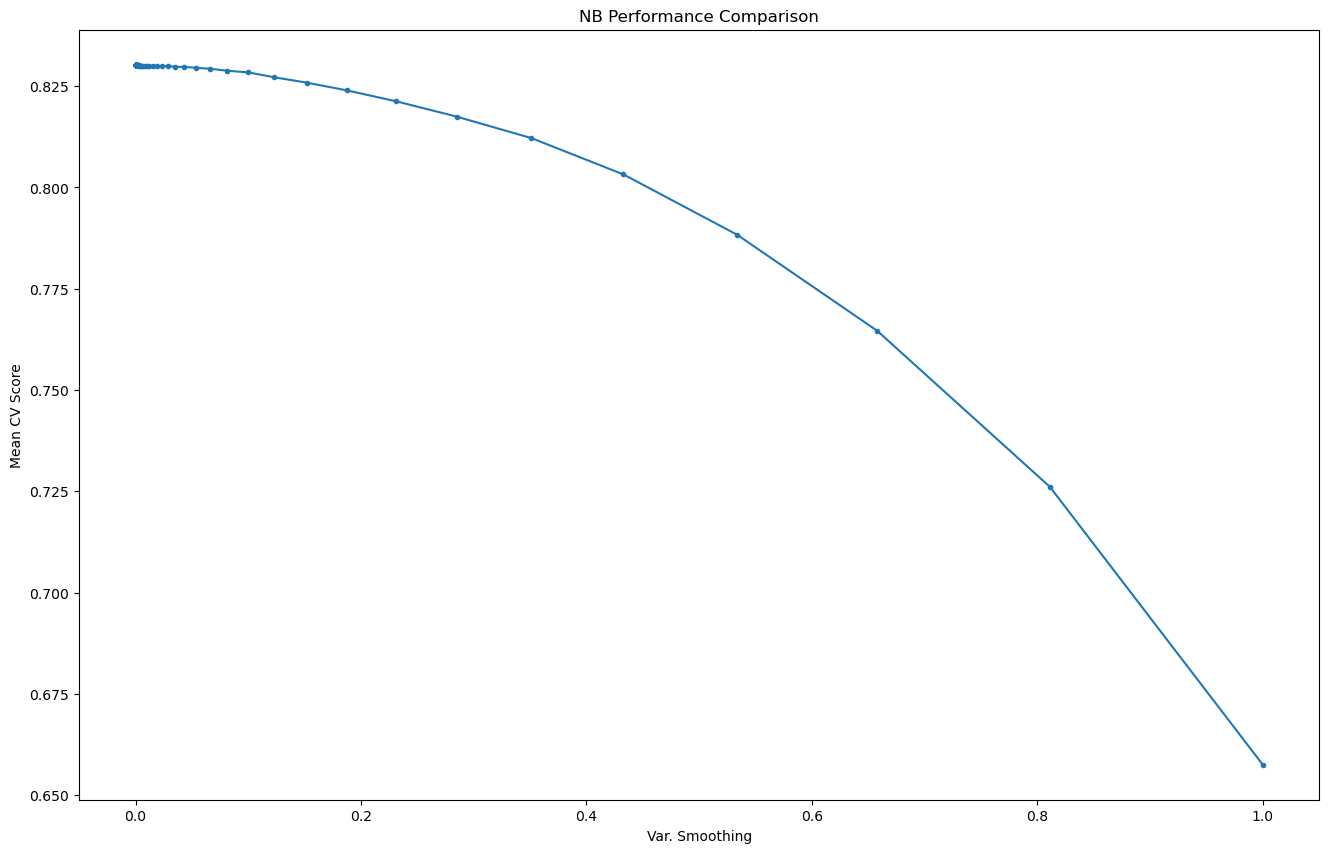

In [210]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X.astype('float'), y.astype('float'), random_state = 42, test_size = 0.3)

In [212]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)
pt=StandardScaler()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed','payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=pt.fit_transform(X_train[[i]])
    X_test[i]=pt.transform(X_test[[i]])

In [213]:
gnb = GaussianNB(var_smoothing= 0.001873817422860383)
gnb.fit(X_train,y_train)

GaussianNB(var_smoothing=0.001873817422860383)

In [214]:
train_pred = gnb.predict(X_train)
test_pred = gnb.predict(X_test)
print(classification_report(y_train, train_pred))
print(classification_report(y_test,test_pred))
print('The train accuracy score is',metrics.accuracy_score(y_train,train_pred))
print('The test accuracy score is',metrics.accuracy_score(y_test,test_pred))
print('The column kappa value is ', metrics.cohen_kappa_score(y_test,test_pred))
fpr, tpr, thresholds = metrics.roc_curve(y_test, test_pred)
print('AUC_score',metrics.auc(fpr,tpr))

              precision    recall  f1-score   support

         0.0       0.83      0.38      0.52     48518
         1.0       0.33      0.80      0.47     18383

    accuracy                           0.50     66901
   macro avg       0.58      0.59      0.49     66901
weighted avg       0.69      0.50      0.51     66901

              precision    recall  f1-score   support

         0.0       0.83      0.38      0.52     20653
         1.0       0.34      0.81      0.47      8020

    accuracy                           0.50     28673
   macro avg       0.59      0.59      0.50     28673
weighted avg       0.70      0.50      0.51     28673

The train accuracy score is 0.49631545118907044
The test accuracy score is 0.5002964461339936
The column kappa value is  0.13110329846825342
AUC_score 0.5935592372866314


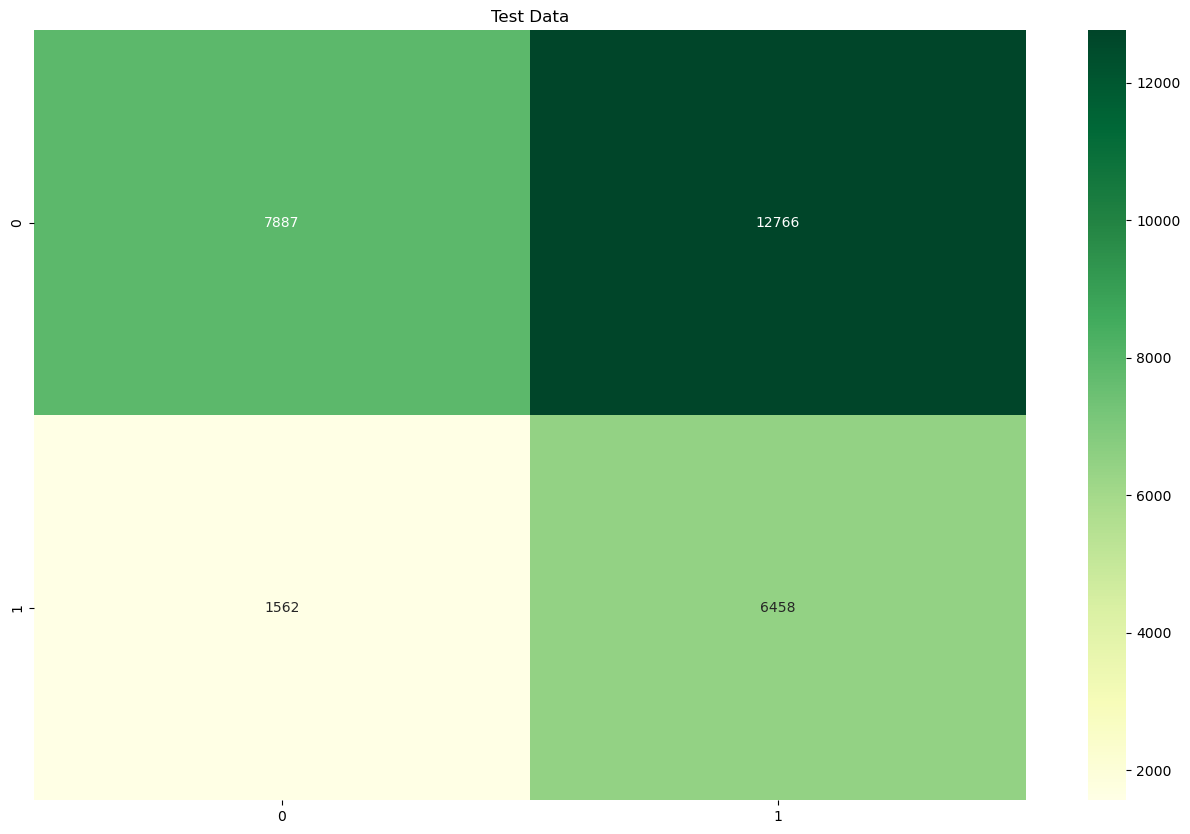

In [215]:
sns.heatmap((metrics.confusion_matrix(y_test,test_pred)),annot=True,fmt='.5g',cmap="YlGn").set_title('Test Data');

#fpr,tpr,threshold=metrics.roc_curve(y_test,test_pred)
print('\n')
#metrics.RocCurveDisplay(fpr,tpr)

In [ ]:
#hyper parameter tuning decreases the all scores then normal GN model

# ANN model

In [86]:
df

device  first_payment_amount   age       city  number_of_cards  \
0          samsung                     0  20.0  Ahmedabad              2.0   
1           xiaomi                     0  20.0      Surat              1.0   
2           xiaomi                     0  20.0      Kullu              1.0   
3          oneplus                     0  20.0     Mumbai              2.0   
4            apple                     0  20.0       Pune              2.0   
...            ...                   ...   ...        ...              ...   
103996     samsung                    42  80.0       Pune              1.0   
103997        vivo                    47  80.0    Shimoga              0.0   
103998      realme                    70  80.0     Mumbai              1.0   
103999      xiaomi                   100  80.0        NCR              0.0   
104000  hmd global                   272  80.0  Bangalore              2.0   

        payments_initiated  payments_failed  payments_completed  \
0                      1.0              0.0                 1.0   
1                      1.0              0.0                 1.0   
2                      2.0              1.0                 1.0   
3                      4.0              1.0                 2.0   
4                      1.0              0.0                 1.0   
...                    ...              ...                 ...   
103996                 2.0              1.0                 1.0   
103997                 1.0              0.0                 1.0   
103998                 2.0              1.0                 1.0   
103999                 1.0              0.0                 1.0   
104000                 1.0              0.0                 1.0   

        payments_completed_amount_first_7days  coins_redeemed_first_7days  \
0                                         0.0                         0.0   
1                                         0.0                         0.0   
2                                         0.0                         0.0   
3                                       322.0                        20.0   
4                                         0.0                         0.0   
...                                       ...                         ...   
103996                                   42.0                         3.0   
103997                                   47.0                        20.0   
103998                                   70.0                         0.0   
103999                                  100.0                        70.0   
104000                                  272.0                       100.0   

        is_referral  visits_feature_1  visits_feature_2  given_permission_1  \
0             False               3.0               0.0                   1   
1              True               0.0               0.0                   1   
2              True               0.0               0.0                   0   
3             False               0.0               0.0                   1   
4             False               0.0               1.0                   1   
...             ...               ...               ...                 ...   
103996         True               0.0               0.0                   1   
103997        False               0.0               0.0                   1   
103998        False               0.0               0.0                   1   
103999         True               0.0               0.0                   0   
104000         True               0.0               0.0                   0   

        given_permission_2  is_churned  
0                        0           0  
1                        0           0  
2                        1           0  
3                        1           0  
4                        1           0  
...                    ...         ...  
103996                   0           1  
103997                   1           1  
103998                   1 

In [103]:
df.reset_index(inplace=True)

In [104]:
df=df.drop('index',axis=1)

In [105]:
X=df.drop(columns=['is_churned','device','city'],axis=1)
y=df.is_churned

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y.astype('float'), random_state = 42, test_size = 0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((66901, 13), (28673, 13), (66901,), (28673,))

In [91]:
sc=StandardScaler()
op=['first_payment_amount','age','number_of_cards','payments_initiated','payments_failed','payments_completed',
'payments_completed_amount_first_7days','coins_redeemed_first_7days','visits_feature_1','visits_feature_2']

for i in op:
    X_train[i]=sc.fit_transform(X_train[[i]])
    X_test[i]=sc.transform(X_test[[i]])

In [92]:
X_train=pd.get_dummies(X_train,drop_first=True)
X_test=pd.get_dummies(X_test,drop_first=True)

In [107]:
X_train.head()

first_payment_amount   age  number_of_cards  payments_initiated  \
5083                     24  24.0              0.0                 1.0   
87260                   286  43.0              1.0                 1.0   
65268                    50  34.0              1.0                 1.0   
2126                     19  23.0              0.0                 1.0   
54658                    30  32.0              2.0                 2.0   

       payments_failed  payments_completed  \
5083               0.0                 1.0   
87260              0.0                 1.0   
65268              0.0                 1.0   
2126               0.0                 1.0   
54658              0.0                 2.0   

       payments_completed_amount_first_7days  coins_redeemed_first_7days  \
5083                                    24.0                         3.0   
87260                                  286.0                       170.0   
65268                                   50.0                        20.0   
2126                                    19.0                        20.0   
54658                                   39.0                        23.0   

      is_referral  visits_feature_1  visits_feature_2  given_permission_1  \
5083            0               1.0               0.0                   1   
87260           1               0.0               0.0                   1   
65268           1               0.0               0.0                   1   
2126            1               0.0               0.0                   1   
54658           0               0.0               0.0                   1   

       given_permission_2  
5083                    0  
87260                   1  
65268                   1  
2126                    0  
54658                   1

In [80]:
import tensorflow as tf
from tensorflow import keras

In [94]:
len(X_train.columns)

13

In [108]:
model=keras.Sequential([
    keras.layers.Dense(13,input_shape=(13,), activation='relu'),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(15, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [109]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 13)                182       
                                                                 
 dense_5 (Dense)             (None, 25)                350       
                                                                 
 dropout_2 (Dropout)         (None, 25)                0         
                                                                 
 dense_6 (Dense)             (None, 15)                390       
                                                                 
 dropout_3 (Dropout)         (None, 15)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 16        
                                                                 
Total params: 938
Trainable params: 938
Non-trainable 

In [28]:
#model.fit(X_train,y_train, epochs=5)

Epoch 1/5
2221/2221 [==============================] - 13s 3ms/step - loss: 0.5476 - accuracy: 0.7426
Epoch 2/5
2221/2221 [==============================] - 6s 3ms/step - loss: 0.5265 - accuracy: 0.7568
Epoch 3/5
2221/2221 [==============================] - 6s 3ms/step - loss: 0.5200 - accuracy: 0.7611
Epoch 4/5
2221/2221 [==============================] - 6s 3ms/step - loss: 0.5165 - accuracy: 0.7634
Epoch 5/5
2221/2221 [==============================] - 6s 3ms/step - loss: 0.5138 - accuracy: 0.7658


In [112]:
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [130]:
model.fit(X_train,y_train, epochs=15,validation_data=(X_test,y_test))

Epoch 1/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5068 - accuracy: 0.7728 - val_loss: 0.5056 - val_accuracy: 0.7773
Epoch 2/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5070 - accuracy: 0.7742 - val_loss: 0.5013 - val_accuracy: 0.7778
Epoch 3/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5066 - accuracy: 0.7734 - val_loss: 0.5035 - val_accuracy: 0.7787
Epoch 4/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5064 - accuracy: 0.7728 - val_loss: 0.5056 - val_accuracy: 0.7745
Epoch 5/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5071 - accuracy: 0.7741 - val_loss: 0.5033 - val_accuracy: 0.7795
Epoch 6/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5061 - accuracy: 0.7751 - val_loss: 0.5020 - val_accuracy: 0.7785
Epoch 7/15
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5062 - accuracy: 0.7744 - val_loss: 0.5003 - val_accuracy:

In [115]:
yts=model.predict(X_test)

897/897 [==============================] - 2s 2ms/step


In [116]:
ytr=model.predict(X_train)

2091/2091 [==============================] - 5s 2ms/step


In [117]:
yts_pred=[]
for i in yts:
    if i>0.5:
        yts_pred.append(1)
    else:
        yts_pred.append(0)

In [118]:
ytr_pred=[]
for i in ytr:
    if i>0.5:
        ytr_pred.append(1)
    else:
        ytr_pred.append(0)

In [134]:
len(yts_pred)

22476

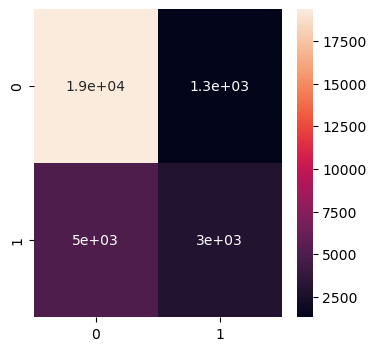

In [119]:
cm= metrics.confusion_matrix(y_test,yts_pred)
matrix=pd.DataFrame(data=cm,index=['Actual:0','Actual:1'], columns=['predicted:0','predicted:1'])
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True)
plt.show()

In [120]:
matrix

predicted:0  predicted:1
Actual:0        19349         1304
Actual:1         5036         2984

In [121]:
print('train tables\n',metrics.classification_report(y_train, ytr_pred),'\n')
print('test tables\n',metrics.classification_report(y_test,np.array(yts_pred)))

train tables
               precision    recall  f1-score   support

         0.0       0.80      0.94      0.86     48518
         1.0       0.69      0.37      0.48     18383

    accuracy                           0.78     66901
   macro avg       0.74      0.65      0.67     66901
weighted avg       0.77      0.78      0.76     66901
 

test tables
               precision    recall  f1-score   support

         0.0       0.79      0.94      0.86     20653
         1.0       0.70      0.37      0.48      8020

    accuracy                           0.78     28673
   macro avg       0.74      0.65      0.67     28673
weighted avg       0.77      0.78      0.75     28673



In [131]:
model.history.history

{'loss': [0.5067545175552368,
  0.5070376992225647,
  0.5065709352493286,
  0.5063928961753845,
  0.507129967212677,
  0.5061150193214417,
  0.5062445402145386,
  0.5051112771034241,
  0.5062795281410217,
  0.5058947801589966,
  0.5064080953598022,
  0.5058310627937317,
  0.5056821703910828,
  0.5051748752593994,
  0.505162239074707],
 'accuracy': [0.772783637046814,
  0.7741737961769104,
  0.7733815908432007,
  0.772783637046814,
  0.774054229259491,
  0.7751453518867493,
  0.7743830680847168,
  0.7757133841514587,
  0.7740990519523621,
  0.7729780077934265,
  0.7724249362945557,
  0.7751453518867493,
  0.7746371626853943,
  0.7748165130615234,
  0.7745474576950073],
 'val_loss': [0.5055740475654602,
  0.5013190507888794,
  0.5034938454627991,
  0.5056187510490417,
  0.5032798051834106,
  0.5019683241844177,
  0.5003479719161987,
  0.4995891749858856,
  0.5016653537750244,
  0.5026429891586304,
  0.5004841089248657,
  0.5032283067703247,
  0.5079629421234131,
  0.5009223222732544,
  0

In [139]:
model.history.history['accuracy']

[0.772783637046814,
 0.7741737961769104,
 0.7733815908432007,
 0.772783637046814,
 0.774054229259491,
 0.7751453518867493,
 0.7743830680847168,
 0.7757133841514587,
 0.7740990519523621,
 0.7729780077934265,
 0.7724249362945557,
 0.7751453518867493,
 0.7746371626853943,
 0.7748165130615234,
 0.7745474576950073]

Text(0.5, 1.0, 'Training and Validation Loss')

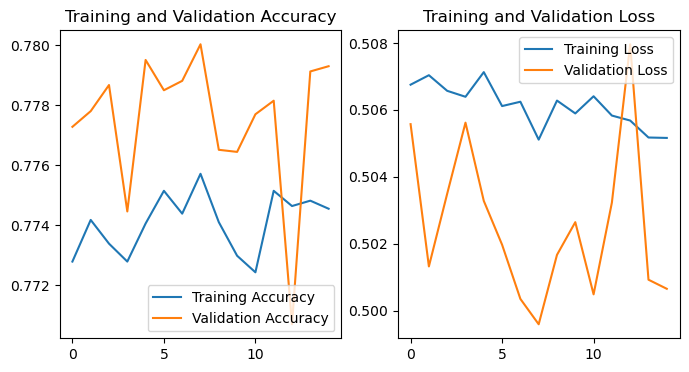

In [142]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(15), model.history.history['accuracy'], label='Training Accuracy')
plt.plot(range(15), model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(15), model.history.history['loss'], label='Training Loss')
plt.plot(range(15), model.history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [143]:
optimizers = ['Adadelta', 'Adagrad', 'Adam', 'RMSprop', 'SGD']

In [145]:
#hyper parameter tuning with optimizer
model.compile(optimizer='adadelta',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [146]:
model.fit(X_train,y_train, epochs=5,validation_data=(X_test,y_test))


Epoch 1/5
2091/2091 [==============================] - 13s 5ms/step - loss: 0.5056 - accuracy: 0.7734 - val_loss: 0.5005 - val_accuracy: 0.7794
Epoch 2/5
2091/2091 [==============================] - 10s 5ms/step - loss: 0.5054 - accuracy: 0.7747 - val_loss: 0.5004 - val_accuracy: 0.7794
Epoch 3/5
2091/2091 [==============================] - 15s 7ms/step - loss: 0.5059 - accuracy: 0.7736 - val_loss: 0.5003 - val_accuracy: 0.7794
Epoch 4/5
2091/2091 [==============================] - 13s 6ms/step - loss: 0.5054 - accuracy: 0.7735 - val_loss: 0.5003 - val_accuracy: 0.7795
Epoch 5/5
2091/2091 [==============================] - 9s 4ms/step - loss: 0.5048 - accuracy: 0.7761 - val_loss: 0.5002 - val_accuracy: 0.7795


Text(0.5, 1.0, 'Training and Validation Loss')

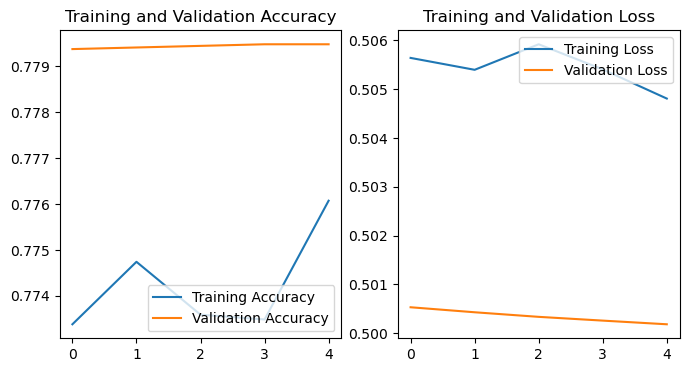

In [147]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(range(5), model.history.history['accuracy'], label='Training Accuracy')
plt.plot(range(5), model.history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(5), model.history.history['loss'], label='Training Loss')
plt.plot(range(5), model.history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
# though its a good  model recall still high, compared with other model

In [218]:
data=[{'method':'Train Test Split(without FE, with outlier)','model':'Naive Bayes','Recall':0.578601,'RoC_AuC':0.675317},
{'method':'Train Test Split(without FE, without outlier)','model':'Naive Bayes','Recall':0.730263,'RoC_AuC':0.637821},
{'method':'Cross Validation(without FE, with outlier)','model':'Naive Bayes','Recall':0.583227,'RoC_AuC':0.738209},
{'method':'Cross Validation(without FE, without outlier)','model':'Naive Bayes','Recall':0.72738,'RoC_AuC':0.698264},
{'method':'Cross Validation(with FE, with outlier)','model':'Gradient Boost','Recall':0.81383,'RoC_AuC':0.982020},
{'method':'Cross Validation(with FE, without outlier)','model':'Gradient Boost','Recall':0.813835,'RoC_AuC':0.982020}]

In [223]:
result=pd.DataFrame(data)

In [226]:
result.sort_values(['Recall','RoC_AuC'],ascending=False)

method           model    Recall  \
5     Cross Validation(with FE, without outlier)  Gradient Boost  0.813835   
4        Cross Validation(with FE, with outlier)  Gradient Boost  0.813830   
1  Train Test Split(without FE, without outlier)     Naive Bayes  0.730263   
3  Cross Validation(without FE, without outlier)     Naive Bayes  0.727380   
2     Cross Validation(without FE, with outlier)     Naive Bayes  0.583227   
0     Train Test Split(without FE, with outlier)     Naive Bayes  0.578601   

    RoC_AuC  
5  0.982020  
4  0.982020  
1  0.637821  
3  0.698264  
2  0.738209  
0  0.675317

In [ ]:
#Cross Validation(without FE, without outlier)Naive Bayes  model is recomended